# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

In [493]:
# If this cell does not work try running `pip install nbformat`

# import io
import nbformat

nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1606


## Group Number : 1

## Student 1 
### Name : Athanasios Georgoutsos
### ID : 6015883

### Individual: CountMin-Sketch

## Student 2
### Name : Amar Mesic
### ID : 5106117

### Individual: Min-wise locality sensitive hashing task

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [283]:
# libraries used in this lab assignment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from nltk import ngrams
import random
import time

from flexfringe import FlexFringe
import os, json
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity


# paths to data files for each scenario
path9 = 'cda-lab3-botnet-detection/dataset_9/capture20110817.binetflow'
path10 = 'cda-lab3-botnet-detection/dataset_10/capture20110818.binetflow'
path11 = 'cda-lab3-botnet-detection/dataset_11/capture20110818-2.binetflow'
path12 = 'cda-lab3-botnet-detection/dataset_12/capture20110819.binetflow'

## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [199]:
data = pd.read_csv(path10)
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


In [200]:
# check unique labels
# we will want to filter out background netflows later
print(len(data['Label'].unique()), list(data['Label'].unique()))

# check unique values for specific features
# label encoder to be used on these
print(len(data['Proto'].unique()), list(data['Proto'].unique()))
print(len(data['Dir'].unique()), list(data['Dir'].unique()))
print(len(data['State'].unique()), list(data['State'].unique()))
print(len(data['sTos'].unique()), list(data['sTos'].unique()))
print(len(data['dTos'].unique()), list(data['dTos'].unique()))

111 ['flow=Background-TCP-Attempt', 'flow=Background-TCP-Established', 'flow=Background-Established-cmpgw-CVUT', 'flow=To-Background-CVUT-Proxy', 'flow=Background', 'flow=Background-UDP-Established', 'flow=Background-UDP-Attempt', 'flow=From-Background-CVUT-Proxy', 'flow=To-Background-UDP-CVUT-DNS-Server', 'flow=To-Background-Grill', 'flow=Background-Attempt-cmpgw-CVUT', 'flow=Background-UDP-NTP-Established-1', 'flow=Background-google-webmail', 'flow=Background-google-analytics11', 'flow=From-Normal-V51-Grill', 'flow=Background-google-analytics10', 'flow=From-Normal-V51-Stribrek', 'flow=Background-google-analytics6', 'flow=To-Background-Stribrek', 'flow=Background-google-analytics9', 'flow=To-Background-CVUT-WebServer', 'flow=Background-google-analytics15', 'flow=Background-google-analytics2', 'flow=From-Normal-V51-Jist', 'flow=Background-google-analytics8', 'flow=To-Background-Jist', 'flow=Background-google-analytics3', 'flow=Background-google-analytics14', 'flow=To-Background-MatLab-

In [201]:
# preprocessing the data
# inspired by the process from the paper by Pellegrino et al.
# "Learning Behavioral Fingerprints from Netflows using Timed Automata"

def preprocess_data(df, date_fix=True, remove_background=True, label_enc=True, label_enc_columns=None):
    
    data = df.copy()

    # account for date format discrepancies
    if date_fix:
        data['StartTime'] = data['StartTime'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d %H:%M:%S.%f') if '.' in x else datetime.strptime(x, '%Y/%m/%d %H:%M:%S'))

    # label netflows as normal, background, or botnet
    # remove all background netflows
    data.loc[(data["Label"].str.startswith("flow=From-Normal")) | (data["Label"].str.startswith("flow=To-Normal")) | (data["Label"].str.startswith("flow=Normal")), "Label"] = "0"

    # botnet traffic
    data.loc[data["Label"].str.startswith("flow=From-Botnet"), "Label"] = "1"

    # remove all background netflows, if specified
    if remove_background:
        # background traffic
        data.loc[(data["Label"].str.startswith("flow=From-Background")) | (data["Label"].str.startswith("flow=To-Background")) | (data["Label"].str.startswith("flow=Background")), "Label"] = "2"
        data = data[data["Label"] != "2"]
    # else, it is considered normal traffic
    else:
        # background traffic
        data.loc[(data["Label"].str.startswith("flow=From-Background")) | (data["Label"].str.startswith("flow=To-Background")) | (data["Label"].str.startswith("flow=Background")), "Label"] = "0"

    # label encode the selected columns
    if label_enc:
        label_enc_columns = label_enc_columns

        for col in label_enc_columns:
            label_enc = LabelEncoder()
            data[col] = label_enc.fit_transform(data[col])

    return data

In [202]:
# preprocess the data
preprocessed_data = preprocess_data(data, date_fix=True, remove_background=True, label_enc=True, label_enc_columns=['Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos'])
preprocessed_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
532,2011-08-18 10:19:15.693956,3587.569824,2,147.32.84.164,60058,4,74.125.232.215,426,57,0,0,3049,978731,245317,0
822,2011-08-18 10:19:18.143576,198.072739,2,147.32.84.164,60575,4,74.125.232.197,943,12,0,0,14,924,462,0
842,2011-08-18 10:19:18.303590,197.928329,2,147.32.84.164,61334,4,209.85.149.138,943,12,0,0,14,924,462,0
1021,2011-08-18 10:19:19.838272,0.000399,3,147.32.84.170,56632,3,147.32.80.9,592,4,0,0,2,400,74,0
1022,2011-08-18 10:19:19.839123,0.000400,3,147.32.84.170,52528,3,147.32.80.9,592,4,0,0,2,400,74,0


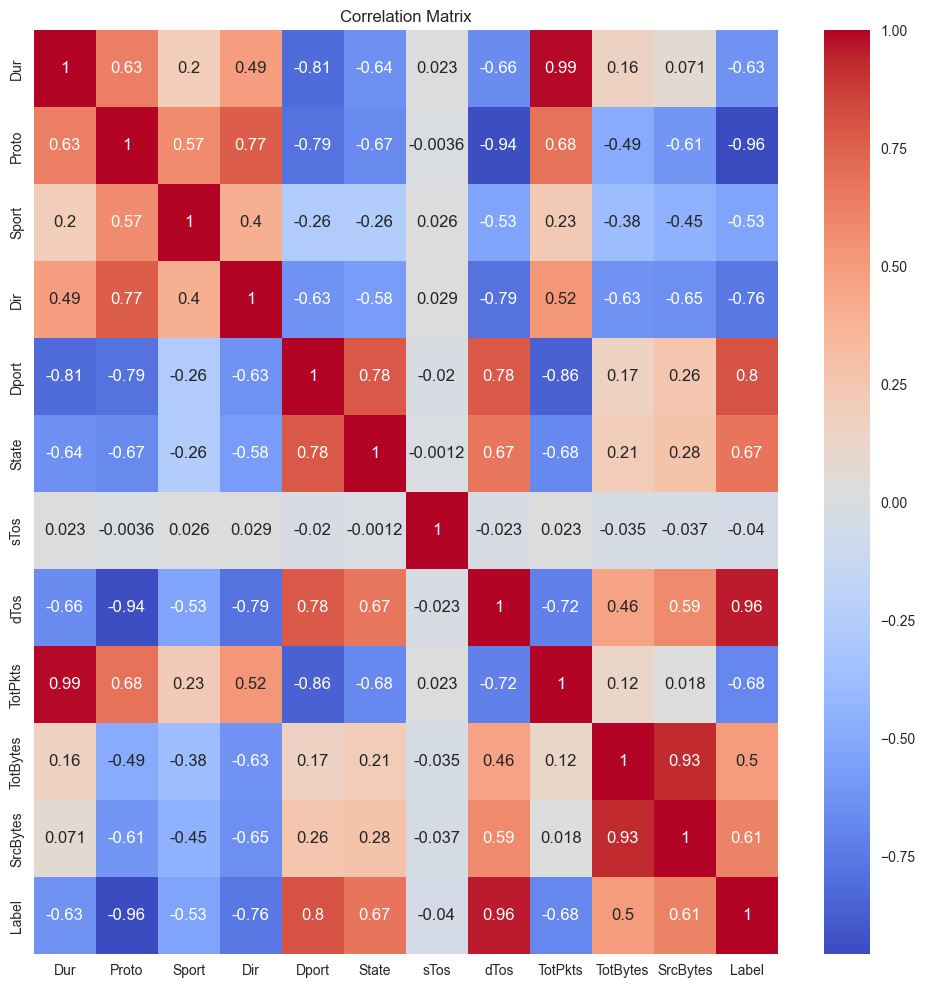

In [203]:
# plot correlation matrix to select features for visualization next
plt.figure(figsize=(12, 12))
correlation_matrix = preprocessed_data.drop(['StartTime', 'SrcAddr', 'DstAddr'], axis=1).corr('spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [204]:
# preprocess data with no label encoding this time
vis_data = preprocess_data(data, date_fix=True, remove_background=True, label_enc=False)

# select data from normal traffic
normal_data = vis_data[vis_data['Label'] == '0']
# print(normal_data.head())

print(normal_data.iloc[0])

# select data from botnet
botnet_data = vis_data[vis_data['Label'] == '1']
# print(botnet_data.head())

print(botnet_data.iloc[0])

StartTime    2011-08-18 10:19:15.693956
Dur                         3587.569824
Proto                               tcp
SrcAddr                   147.32.84.164
Sport                             54784
Dir                                 <?>
DstAddr                  74.125.232.215
Dport                               443
State                             PA_PA
sTos                                0.0
dTos                                0.0
TotPkts                            3049
TotBytes                         978731
SrcBytes                         245317
Label                                 0
Name: 532, dtype: object
StartTime    2011-08-18 10:37:58.448307
Dur                            0.000342
Proto                               udp
SrcAddr                   147.32.84.165
Sport                              1025
Dir                                 <->
DstAddr                     147.32.80.9
Dport                                53
State                               CON
sTos           

In [212]:
# an infected host is 147.32.84.165, let's filter for this one
infected_host = '147.32.84.165'
infected_host_data = botnet_data[(botnet_data['SrcAddr'] == infected_host) | (botnet_data['DstAddr'] == infected_host)]

# consider normal traffic from all benign hosts
benign_host_data = normal_data

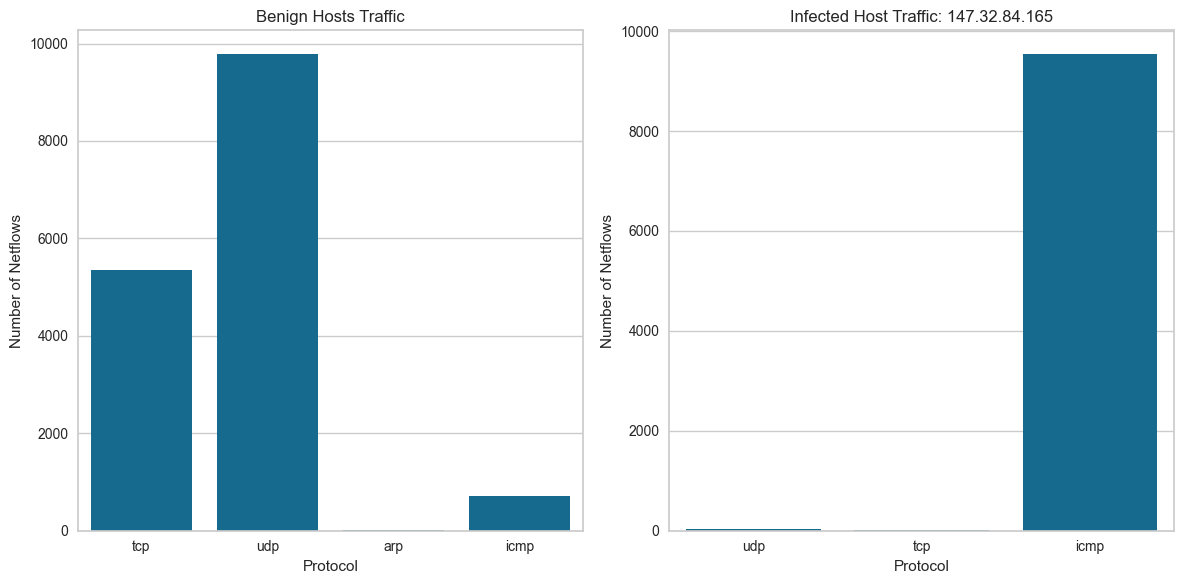

In [213]:
# plot the number of netflows per protocol for infected host and normal traffic
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Proto', data=benign_host_data)
plt.title('Benign Hosts Traffic')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Proto', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

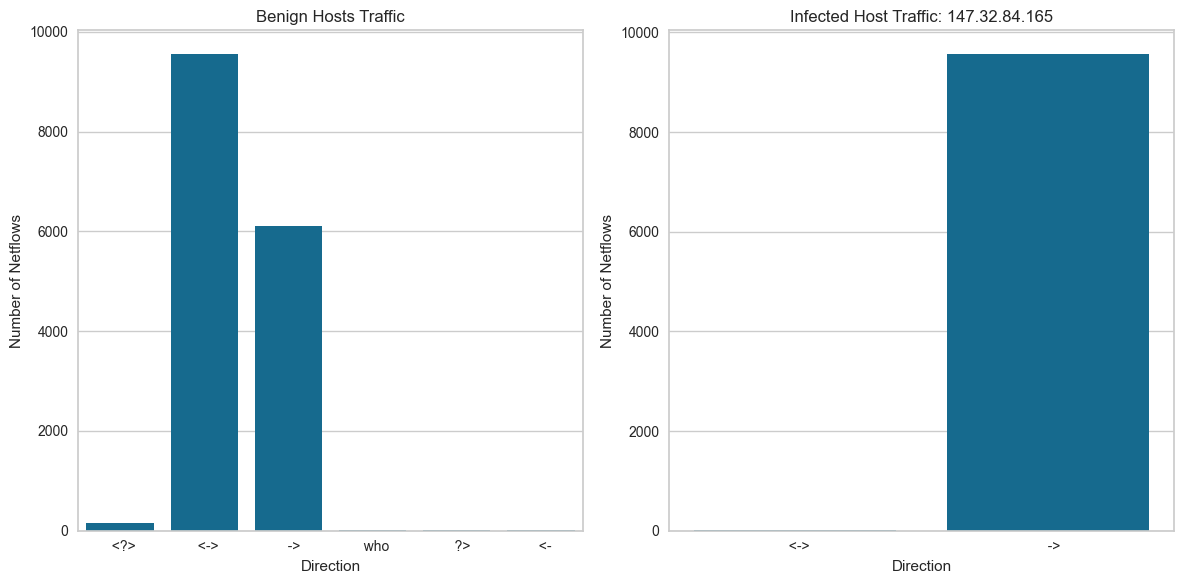

In [214]:
# plot the number of netflows per direction for infected host and normal traffic
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Dir', data=benign_host_data)
plt.title('Benign Hosts Traffic')
plt.xlabel('Direction')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Dir', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Direction')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

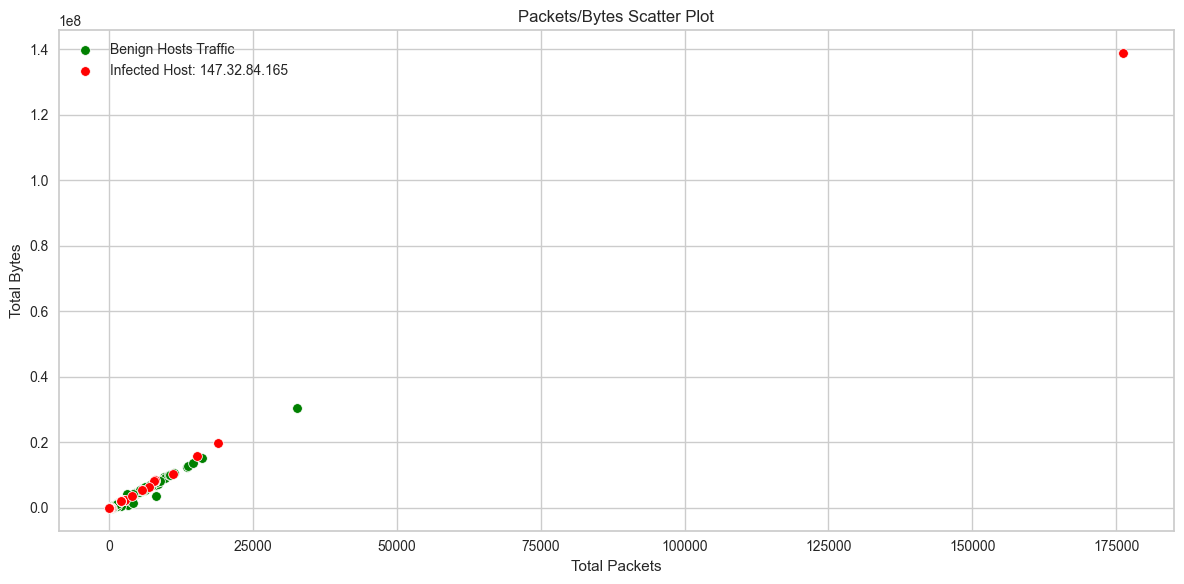

In [215]:
# scatter plot the total number of packets for infected host and normal traffic
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
sns.scatterplot(x='TotPkts', y='TotBytes', data=benign_host_data, color='green', label='Benign Hosts Traffic')
# plt.title('Benign Host Traffic: 147.32.84.170')
# plt.xlabel('Total Packets')
# plt.ylabel('Total Bytes')

# plt.subplot(1, 2, 2)
sns.scatterplot(x='TotPkts', y='TotBytes', data=infected_host_data, color='red', label='Infected Host: 147.32.84.165')
plt.title('Packets/Bytes Scatter Plot')
plt.xlabel('Total Packets')
plt.ylabel('Total Bytes')

plt.legend()
plt.tight_layout()
plt.show()

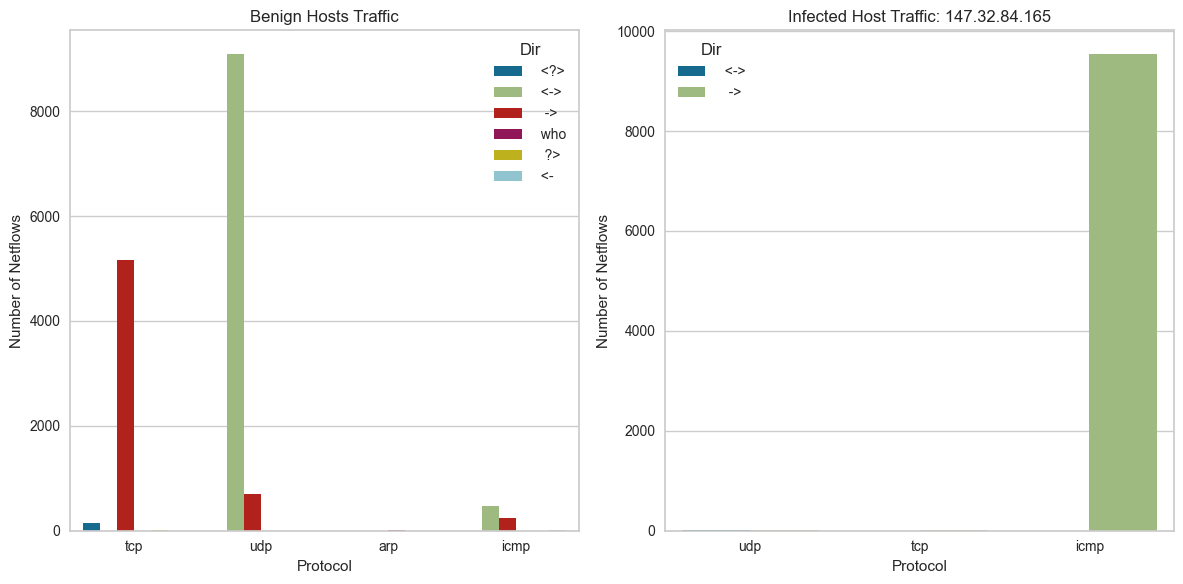

In [216]:
# combine the features into one plot - count of netflows per protocol and direction
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Proto', hue='Dir', data=benign_host_data)
plt.title('Benign Hosts Traffic')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Proto', hue='Dir', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

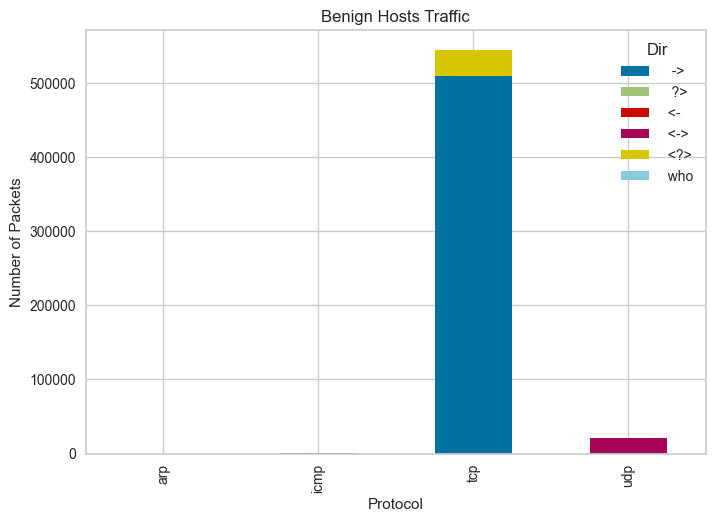

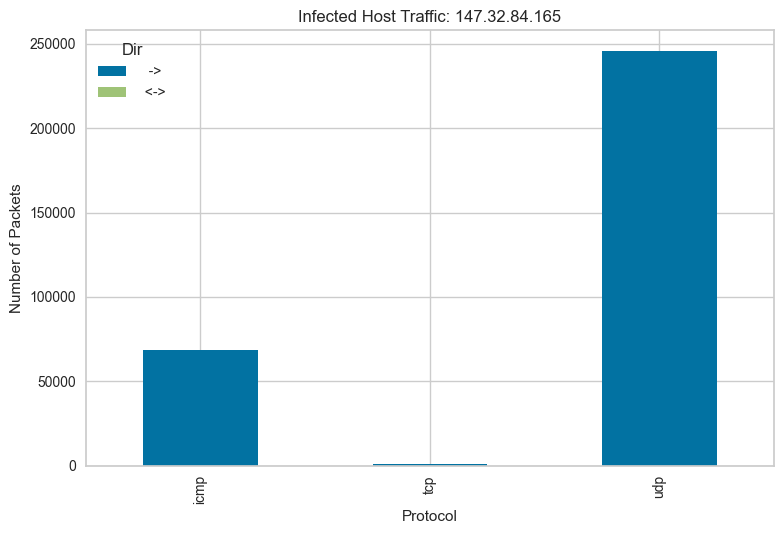

In [217]:
# plot total number of packets for each protocol-direction combination
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
benign_host_data.groupby(['Proto', 'Dir'])['TotPkts'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Benign Hosts Traffic')
plt.xlabel('Protocol')
plt.ylabel('Number of Packets')

# plt.subplot(1, 2, 2)
infected_host_data.groupby(['Proto', 'Dir'])['TotPkts'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol')
plt.ylabel('Number of Packets')

plt.tight_layout()
plt.show()

### 1b. Discretize selected features

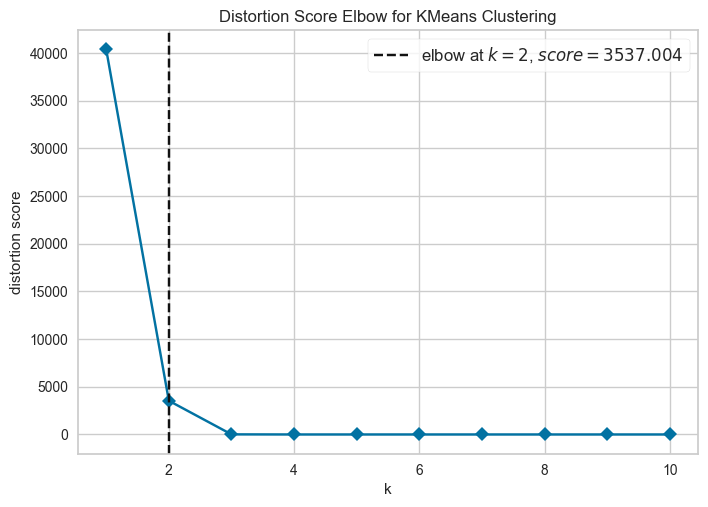

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [218]:
# Elbow technique to find optimal k for k-means clustering - protocol

model = KMeans()
elbow_visualizer = KElbowVisualizer(model,timings=False,k=(1,11))
# Fit the data to the visualizer
elbow_visualizer.fit(preprocessed_data[['Proto']])     
# Finalize and render the figure
elbow_visualizer.show()

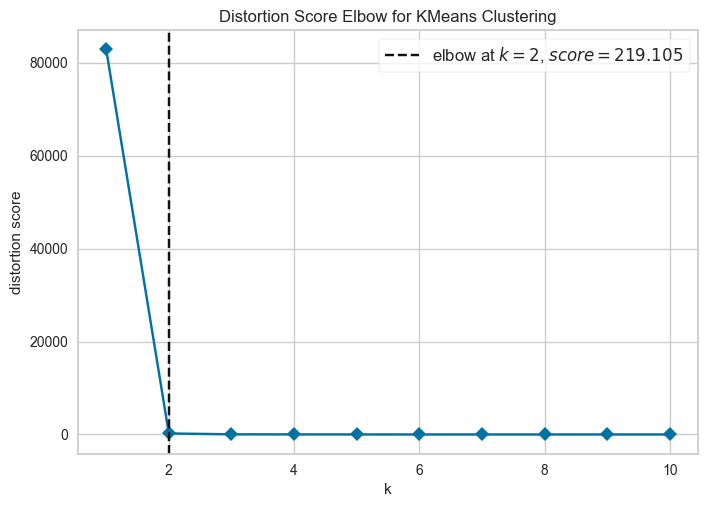

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [219]:
# Elbow technique to find optimal k for k-means clustering - total packets

model = KMeans()
elbow_visualizer = KElbowVisualizer(model,timings=False,k=(1,11))
# Fit the data to the visualizer
elbow_visualizer.fit(preprocessed_data[['Dir']])     
# Finalize and render the figure
elbow_visualizer.show()

In [220]:
# discretization with k-means clustering
def discretize_data(df, columns, k_values):
    
    data = df.copy()
    
    for col, k in zip(columns, k_values):
        kmeans = KMeans(n_clusters=k, random_state=0)
        data[col] = kmeans.fit_predict(data[[col]])
    
    return data

In [221]:
# discretize the selected features - protocol and total packets
discr_data = discretize_data(preprocessed_data, ['Proto', 'Dir'], [3, 2])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
532,2011-08-18 10:19:15.693956,3587.569824,2,147.32.84.164,60058,1,74.125.232.215,426,57,0,0,3049,978731,245317,0
822,2011-08-18 10:19:18.143576,198.072739,2,147.32.84.164,60575,1,74.125.232.197,943,12,0,0,14,924,462,0
842,2011-08-18 10:19:18.303590,197.928329,2,147.32.84.164,61334,1,209.85.149.138,943,12,0,0,14,924,462,0
1021,2011-08-18 10:19:19.838272,0.000399,1,147.32.84.170,56632,1,147.32.80.9,592,4,0,0,2,400,74,0
1022,2011-08-18 10:19:19.839123,0.000400,1,147.32.84.170,52528,1,147.32.80.9,592,4,0,0,2,400,74,0


In [223]:
print(discr_data['Proto'].unique())
print(discr_data['Dir'].unique())

[2 1 0]
[1 0]


In [224]:
# function to combine discretized features into one
def attribute_mappings(df, features):
    
    data = df.copy()

    code = 0
    space_size = 1
    for f in features:
        space_size = space_size*len(data[f].unique())

    for f in features:
        code += data[f]*space_size/len(data[f].unique())
        space_size = space_size/len(data[f].unique())

    return code

In [225]:
# combine discretized protocol and total packets into one feature
discr_data['Combined'] = attribute_mappings(discr_data, ['Dir', 'Proto'])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Combined
532,2011-08-18 10:19:15.693956,3587.569824,2,147.32.84.164,60058,1,74.125.232.215,426,57,0,0,3049,978731,245317,0,5.0
822,2011-08-18 10:19:18.143576,198.072739,2,147.32.84.164,60575,1,74.125.232.197,943,12,0,0,14,924,462,0,5.0
842,2011-08-18 10:19:18.303590,197.928329,2,147.32.84.164,61334,1,209.85.149.138,943,12,0,0,14,924,462,0,5.0
1021,2011-08-18 10:19:19.838272,0.000399,1,147.32.84.170,56632,1,147.32.80.9,592,4,0,0,2,400,74,0,4.0
1022,2011-08-18 10:19:19.839123,0.000400,1,147.32.84.170,52528,1,147.32.80.9,592,4,0,0,2,400,74,0,4.0


In [226]:
# check unique values for the combined feature
print(len(discr_data['Combined'].unique()), list(discr_data['Combined'].unique()))

6 [5.0, 4.0, 2.0, 3.0, 1.0, 0.0]


In [227]:
# check combined feature for an infected host and a benign host
# an infected host is 147.32.84.165, let's filter for this one
infected_host = '147.32.84.165'
infected_host_data = discr_data[((discr_data['SrcAddr'] == infected_host) | (discr_data['DstAddr'] == infected_host)) & (discr_data['Label'] == '1')]

# get normal data from all benign hosts
benign_host_data = discr_data[(discr_data['Label'] == '0')]

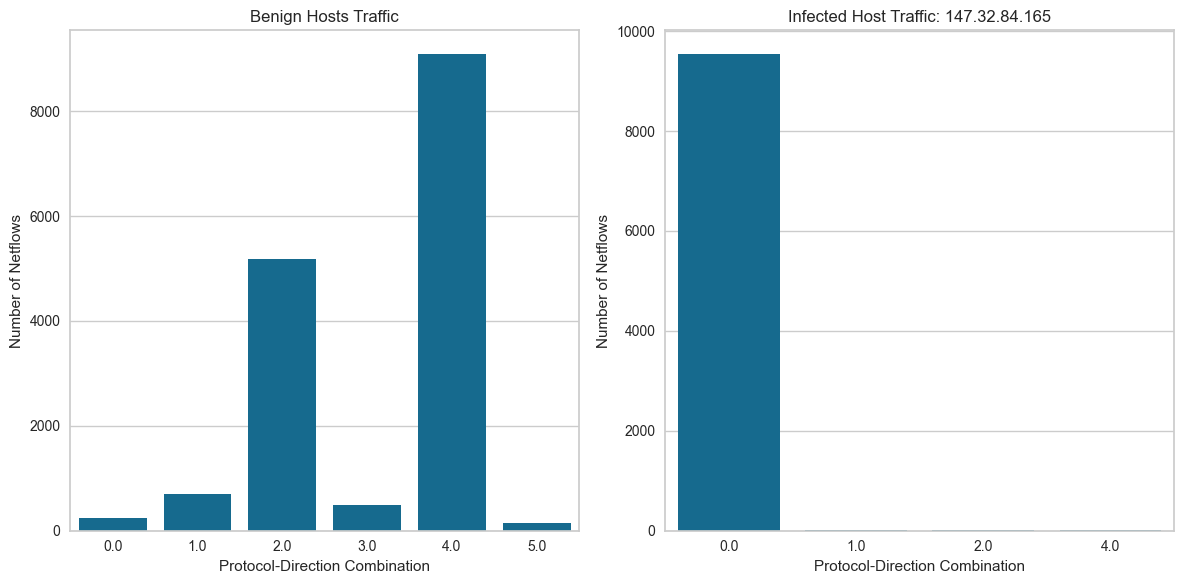

In [228]:
# plot the combined feature for infected host and normal traffic
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Combined', data=benign_host_data)
plt.title('Benign Hosts Traffic')
plt.xlabel('Protocol-Direction Combination')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Combined', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol-Direction Combination')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

### 1c. Answers and explanation

First, we are looking at the bottom horizontal line of the correlation matrix to find features with strong relationships with the Label (benign/infected). We can see that the protocol, direction and total packets showcase strong/semi-strong negative correlation with the Label, so we focus on these. We select a benign and an infected host and analyze their features.

1. **Protocol**: We observe that the infected host uses almost solely the ICMP protocol, while the benign host uses mostly UDP and TCP.

2. **Direction**: The infected host communication is almost always one-way, while for the benign host it is more often both-ways.

3. **Total Packets**: Here, there is a big overlap between the infected and the benign host, as for both, communication involves up to 20k packets containing up to 20 MBytes of information. Except of one specific case, where the infected host sent around 175k packets, there is no clear distinction to be made.

We then went on to discretize the protocol and direction of communication. We used the Elbow method to find the optimal k clusters for each of them (for Protocol we select 3, as there is a considerable distortion difference from the value indicated by Elbow). After discretization and combining the features, as in the provided paper by Pellegrino, the new combined feature has 6 unique values. Our final plot shows that the combination of protocol-direction could be highly effective for recognizing infected hosts.


## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


In [229]:
# get n-grams from the combined discretized features
combined_ngrams = list(ngrams(discr_data['Combined'], 3))
print("First 10 3-grams of the combined discretized features:")
print(combined_ngrams[:10])

First 10 3-grams of the combined discretized features:
[(5.0, 5.0, 5.0), (5.0, 5.0, 4.0), (5.0, 4.0, 4.0), (4.0, 4.0, 2.0), (4.0, 2.0, 5.0), (2.0, 5.0, 5.0), (5.0, 5.0, 5.0), (5.0, 5.0, 5.0), (5.0, 5.0, 5.0), (5.0, 5.0, 5.0)]


In [230]:
# show unique 3-grams
unique_ngrams = list(set(combined_ngrams))
print("Number of unique 3-grams:", len(unique_ngrams))

# count the number of occurrences of each 3-gram
ngram_counts = {ngram: combined_ngrams.count(ngram) for ngram in unique_ngrams}
print("\nFirst 10 3-grams with their counts:")
for i in range(10):
    print(list(ngram_counts.items())[i])

Number of unique 3-grams: 169

First 10 3-grams with their counts:
((5.0, 3.0, 3.0), 6)
((5.0, 4.0, 2.0), 1)
((4.0, 0.0, 1.0), 4)
((2.0, 2.0, 5.0), 3)
((0.0, 3.0, 3.0), 20)
((3.0, 2.0, 1.0), 1)
((5.0, 2.0, 4.0), 3)
((1.0, 3.0, 0.0), 8)
((5.0, 5.0, 3.0), 1)
((3.0, 3.0, 2.0), 3)


In [60]:
# implementation of Count-Min sketch
class CountMinSketch:
    
    def __init__(self, width, depth):
        self.width = width
        self.depth = depth
        self.table = np.zeros((depth, width))

        # pairwise independent hash functions
        self.hash_functions = [(np.random.randint(1, 10**6), np.random.randint(0, 10**6)) for _ in range(depth)]
    
    def update(self, key, count=1):
        for i in range(self.depth):
            hash_value = hash(key) ^ self.hash_functions[i][0]
            index = hash_value % self.width
            self.table[i][index] += count
    
    def query(self, key):
        min_count = np.inf
        for i in range(self.depth):
            hash_value = hash(key) ^ self.hash_functions[i][0]
            index = hash_value % self.width
            min_count = min(min_count, self.table[i][index])
        return min_count
    

# mean squared error function for Count-Min sketch frequencies
def mean_abs_error(true_counts, estimated_counts):
    return np.mean(abs(true_counts - estimated_counts))

# function for creating a Count-Min sketch with given width and depth
# returns the predicted frequencies of the 3-grams
def create_count_min_sketch(data, unique_ngrams, width, depth):
    
    # create the Count-Min sketch
    cms = CountMinSketch(width, depth)
    
    # update the sketch with the 3-grams
    for ngram in data:
        cms.update(ngram)
    
    estimated_counts = {}
    for ngram in unique_ngrams:
        estimated_counts[ngram] = cms.query(ngram)
    
    return estimated_counts

In [231]:
# NOTE: takes about 1.5 minutes to run
# calculate approximate frequencies of the 3-grams using Count-Min sketch
# for different widths and depths

widths = [4, 8, 12, 16, 20, 24, 28, 32]
depths = [2, 4, 6, 8, 10]

freq_errors = np.zeros((len(widths), len(depths)))

for i, width in enumerate(widths):
    for j, depth in enumerate(depths):
        estimated_counts = create_count_min_sketch(combined_ngrams, list(ngram_counts.keys()), width, depth)
        # print(estimated_counts[:10])
        # print(np.array(list(ngram_counts.values())[:10]))
        freq_errors[i, j] = mean_abs_error(np.array(list(ngram_counts.values())), np.array(list(estimated_counts.values())))

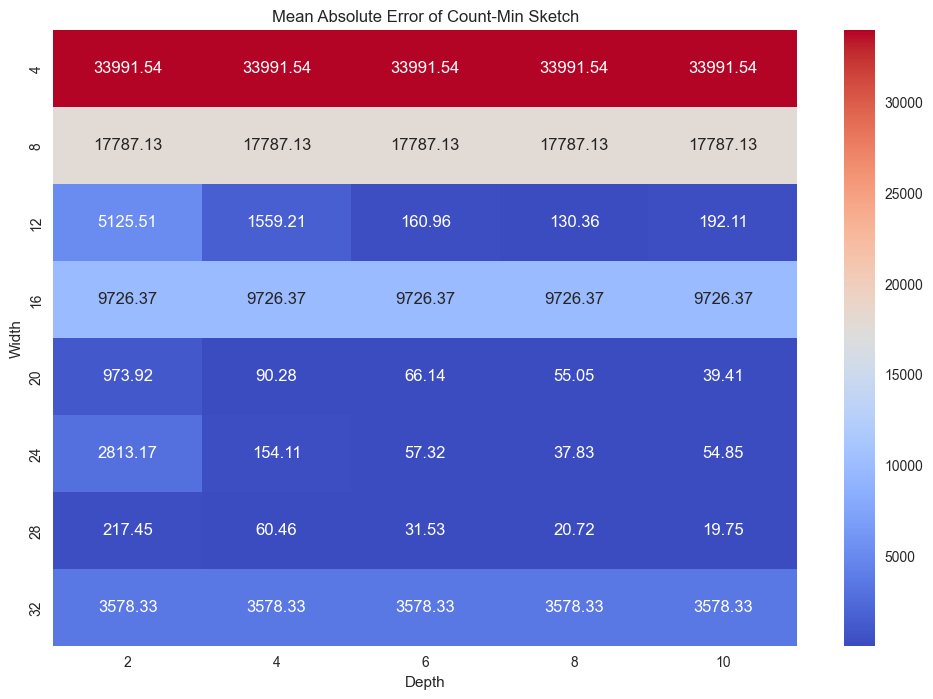

In [232]:
# plot heatmap of mean squared errors for different widths and depths
plt.figure(figsize=(12, 8))
sns.heatmap(freq_errors, annot=True, fmt=".2f", xticklabels=depths, yticklabels=widths, cmap='coolwarm')
plt.title('Mean Absolute Error of Count-Min Sketch')
plt.xlabel('Depth')
plt.ylabel('Width')
plt.show()

In [459]:
# check for a specific combination the top 10 most frequent 3-grams
# and their estimated frequencies using Count-Min sketch

width, depth = 20, 4
estimated_counts = create_count_min_sketch(combined_ngrams, list(ngram_counts.keys()), width, depth)
sorted_estimated_counts = {k: v for k, v in sorted(estimated_counts.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 most frequent 3-grams and their estimated frequencies using Count-Min sketch:")
for i, (ngram, count) in enumerate(sorted_estimated_counts.items()):
    if i == 10:
        break
    print(ngram, count)

Top 10 most frequent 3-grams and their estimated frequencies using Count-Min sketch:
(0.0, 0.0, 0.0) 105503.0
(4.0, 4.0, 4.0) 3090.0
(4.0, 4.0, 2.0) 2975.0
(0.0, 1.0, 3.0) 2856.0
(2.0, 4.0, 4.0) 2756.0
(3.0, 3.0, 1.0) 2596.0
(4.0, 4.0, 3.0) 2483.0
(4.0, 2.0, 4.0) 2483.0
(2.0, 2.0, 2.0) 1574.0
(1.0, 4.0, 1.0) 704.0


In [460]:
# actual frequencies of the above 3-grams
print("\nActual frequencies of the top 10 most frequent 3-grams:")
for i, (ngram, count) in enumerate(sorted(ngram_counts.items(), key=lambda item: item[1], reverse=True)):
    if i == 10:
        break
    print(ngram, count)


Actual frequencies of the top 10 most frequent 3-grams:
(0.0, 0.0, 0.0) 105428
(4.0, 4.0, 4.0) 3069
(4.0, 4.0, 2.0) 2929
(2.0, 4.0, 4.0) 2717
(4.0, 2.0, 4.0) 2412
(2.0, 2.0, 2.0) 1553
(4.0, 2.0, 2.0) 509
(2.0, 2.0, 4.0) 498
(1.0, 1.0, 1.0) 290
(3.0, 3.0, 3.0) 236


### 2b. Analysis and answers to the questions

In terms of space and time complexity, Count-Min estimation is definitely an efficient option. For calculating the actual frequency of the 3-grams, we would need as much space as the amount of unique 3-grams, which in our case is 169. On the contrary, by selecting the right combination of width and depth for Count-Min sketch, we can fit the frequencies in an even smaller space. For instance, above, we have selected to show the top results for width=20 and depth=4, requiring a space of 80. Then, for the baseline case, we would need to search across the selected datastructure with a suitable algorithm to find the requested 3-gram. This could be done with binary search in O(logN). With Count-Min sketch, however, this can be done in O(1). 

Finally, regarding performance, we can look also at our heatmap, focusing on width-depth combinations that do not surpass 169 (supposing we want a smaller space than the baseline case). We can see that there is a significant mean absolute error between the actual and the approximated frequencies of the 3-grams. Based on its preferences, the user would have to resolve the performance/space-time efficiency tradeoff and select the parameters that suit him better. Just above, we printed the top 3-grams, based on Count-Min sketch, and the actual top 3-grams with their actual frequency. We can see that there are some misses from the Count-Min sketch, while its errors are overestimations of the actual frequencies. I would suggest the usage of Count-Min sketch when there are very restricting computational limitations and a reasonable approximation error is acceptable.  

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

In [88]:
preprocessed_data.columns

Index(['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr',
       'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes',
       'Label'],
      dtype='object')

In [205]:
# cols = ['Dur', 'Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos', 'TotPkts']
cols = ['StartTime', 'Dur', 'Proto', 'Sport', 'Dir',
       'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes']

# # Use this code to find the elbow for each column
# for col in cols:
#     print(col)
#     model = KMeans()
#     elbow_visualizer = KElbowVisualizer(model,timings=False,k=(1,10))
#     # Fit the data to the visualizer
#     elbow_visualizer.fit(preprocessed_data[[col]])     
#     # Finalize and render the figure
#     elbow_visualizer.set_title(col)
#     elbow_visualizer.show()

In [95]:
# gram_df = discretize_data(preprocessed_data, cols, [2, 2, 3, 2, 3, 2, 2, 2, 2])[cols]

gram_df = discretize_data(preprocessed_data, cols, [2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2])[cols]
gram_df.head()

,StartTime,Dur,Proto,Sport,Dir,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes
532,0,2,1,1,1,1,0,0,1,0,0,0
822,0,0,1,1,1,0,0,0,1,0,0,0
842,0,0,1,1,1,0,0,0,1,0,0,0
1021,0,0,1,1,1,1,0,0,1,0,0,0
1022,0,0,1,1,1,1,0,0,1,0,0,0


In [96]:
data.shape, gram_df.shape

((1309791, 15), (122199, 12))

In [112]:
# Generate all possible 3-grams
def gen_ngram(row):
    return list(ngrams(row, 3))

all_ngrams = gram_df.apply(gen_ngram, axis=1, result_type='expand')
all_ngrams

,0,1,2,3,4,5,6,7,8,9
532,"(0, 2, 1)","(2, 1, 1)","(1, 1, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
822,"(0, 0, 1)","(0, 1, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)","(0, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
842,"(0, 0, 1)","(0, 1, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)","(0, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
1021,"(0, 0, 1)","(0, 1, 1)","(1, 1, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
1022,"(0, 0, 1)","(0, 1, 1)","(1, 1, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...
1309670,"(1, 0, 0)","(0, 0, 0)","(0, 0, 1)","(0, 1, 2)","(1, 2, 0)","(2, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
1309736,"(1, 0, 0)","(0, 0, 0)","(0, 0, 1)","(0, 1, 2)","(1, 2, 0)","(2, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
1309782,"(1, 0, 1)","(0, 1, 1)","(1, 1, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"
1309783,"(1, 0, 1)","(0, 1, 1)","(1, 1, 1)","(1, 1, 1)","(1, 1, 0)","(1, 0, 0)","(0, 0, 1)","(0, 1, 0)","(1, 0, 0)","(0, 0, 0)"


In [113]:
unique_ngrams = all_ngrams.apply(set, axis=1)
unique_ngrams

532        {(0, 2, 1), (2, 1, 1), (1, 1, 0), (0, 1, 0), (...
822        {(1, 1, 0), (0, 1, 0), (0, 0, 0), (1, 0, 0), (...
842        {(1, 1, 0), (0, 1, 0), (0, 0, 0), (1, 0, 0), (...
1021       {(1, 1, 0), (0, 1, 0), (0, 0, 0), (1, 0, 0), (...
1022       {(1, 1, 0), (0, 1, 0), (0, 0, 0), (1, 0, 0), (...
                                 ...                        
1309670    {(0, 1, 0), (1, 2, 0), (0, 0, 0), (1, 0, 0), (...
1309736    {(0, 1, 0), (1, 2, 0), (0, 0, 0), (1, 0, 0), (...
1309782    {(1, 0, 1), (1, 1, 0), (0, 1, 0), (0, 0, 0), (...
1309783    {(1, 0, 1), (1, 1, 0), (0, 1, 0), (0, 0, 0), (...
1309784    {(1, 0, 1), (1, 1, 0), (0, 1, 0), (0, 0, 0), (...
Length: 122199, dtype: object

In [129]:
# Define the reference list with all possible tuples
unique = unique_ngrams.explode().unique()
reference_list = set(unique)

def binarize(input_set):
    return [1 if item in input_set else 0 for item in reference_list]

bin_mat = unique_ngrams.apply(binarize)
bin_mat = np.array(bin_mat.to_list()).T

reference_list, bin_mat, bin_mat.shape

({(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 0),
  (0, 1, 1),
  (0, 1, 2),
  (0, 2, 0),
  (0, 2, 1),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (2, 0, 0),
  (2, 0, 1),
  (2, 1, 0),
  (2, 1, 1)},
 array([[1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 0]]),
 (20, 122199))

### Generate Hash Functions

In [122]:
num_hashes = 20  # Number of hash functions
max_int = 2**32 - 1

hash_functions = [
    (random.randint(1, max_int), random.randint(0, max_int)) for _ in range(num_hashes)
]

# Hash function: h(x) = (a * x + b) % p
def hash_func(a, b, x, p=127):
    return (a * x + b) % p

### Perform Min-wise LSH

In [124]:
num_rows, num_docs = bin_mat.shape
min_hash_signatures = np.full((num_hashes, num_docs), max_int)

for i, (a, b) in enumerate(hash_functions):
    for r in range(num_rows):
        hash_value = hash_func(a, b, r)
        min_hash_signatures[i, bin_mat[r] == 1] = np.minimum(min_hash_signatures[i, bin_mat[r] == 1], hash_value)


print("Min-Hash Signatures:")
min_hash_signatures, min_hash_signatures.shape

Min-Hash Signatures:


(array([[12, 33, 33, ..., 20, 20, 20],
        [ 0,  6,  6, ...,  6,  6,  6],
        [13, 13, 13, ...,  6,  6,  6],
        ...,
        [ 4,  4,  4, ...,  4,  4,  4],
        [84, 84, 84, ..., 84, 84, 84],
        [15, 15, 15, ..., 15, 15, 15]]),
 (20, 122199))

### Compare MWLSH to True Jaccard Similarity

In [131]:
# test the performance of the Min-Hash signatures on ten randomly sampled documents
sampled_docs = np.random.choice(num_docs, 10, replace=False)
sampled_docs

array([ 90229,  73358,  84500, 108629,  16929,  99918,  32512,  38374,
        93071,  80300])

In [132]:
# Function to calculate estimated Jaccard similarity using Min-Hash signatures
def estimated_jaccard_similarity(min_hash_signatures, doc_idx1, doc_idx2):
    sig1 = min_hash_signatures[:, doc_idx1]
    sig2 = min_hash_signatures[:, doc_idx2]
    return np.sum(sig1 == sig2) / num_hashes

# Calculate pairwise estimated Jaccard similarity for sampled documents
estimated_similarities = np.zeros((len(sampled_docs), len(sampled_docs)))

for i in range(len(sampled_docs)):
    for j in range(len(sampled_docs)):
        estimated_similarities[i, j] = estimated_jaccard_similarity(min_hash_signatures, sampled_docs[i], sampled_docs[j])

print("Estimated Jaccard Similarity Matrix (Min-Hash):")
estimated_similarities

Estimated Jaccard Similarity Matrix (Min-Hash):


array([[1.  , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.5 , 0.35, 1.  , 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.5 , 1.  , 0.35, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]])

In [133]:
# Function to calculate true Jaccard similarity
def true_jaccard_similarity(original_matrix, doc_idx1, doc_idx2):
    set1 = original_matrix.iloc[doc_idx1]
    set2 = original_matrix.iloc[doc_idx2]
    intersection = np.sum(np.logical_and(set1, set2))
    union = np.sum(np.logical_or(set1, set2))
    return intersection / union

# Calculate pairwise true Jaccard similarity for sampled documents
true_similarities = np.zeros((len(sampled_docs), len(sampled_docs)))

for i in range(len(sampled_docs)):
    for j in range(len(sampled_docs)):
        true_similarities[i, j] = true_jaccard_similarity(gram_df, sampled_docs[i], sampled_docs[j])

print("True Jaccard Similarity Matrix (Original):")
true_similarities

True Jaccard Similarity Matrix (Original):


array([[1.        , 0.33333333, 0.        , 0.66666667, 0.33333333,
        0.66666667, 0.33333333, 0.33333333, 0.66666667, 0.33333333],
       [0.33333333, 1.        , 0.16666667, 0.66666667, 1.        ,
        0.66666667, 1.        , 1.        , 0.66666667, 1.        ],
       [0.        , 0.16666667, 1.        , 0.14285714, 0.16666667,
        0.14285714, 0.16666667, 0.16666667, 0.14285714, 0.16666667],
       [0.66666667, 0.66666667, 0.14285714, 1.        , 0.66666667,
        1.        , 0.66666667, 0.66666667, 1.        , 0.66666667],
       [0.33333333, 1.        , 0.16666667, 0.66666667, 1.        ,
        0.66666667, 1.        , 1.        , 0.66666667, 1.        ],
       [0.66666667, 0.66666667, 0.14285714, 1.        , 0.66666667,
        1.        , 0.66666667, 0.66666667, 1.        , 0.66666667],
       [0.33333333, 1.        , 0.16666667, 0.66666667, 1.        ,
        0.66666667, 1.        , 1.        , 0.66666667, 1.        ],
       [0.33333333, 1.        , 0.1666666

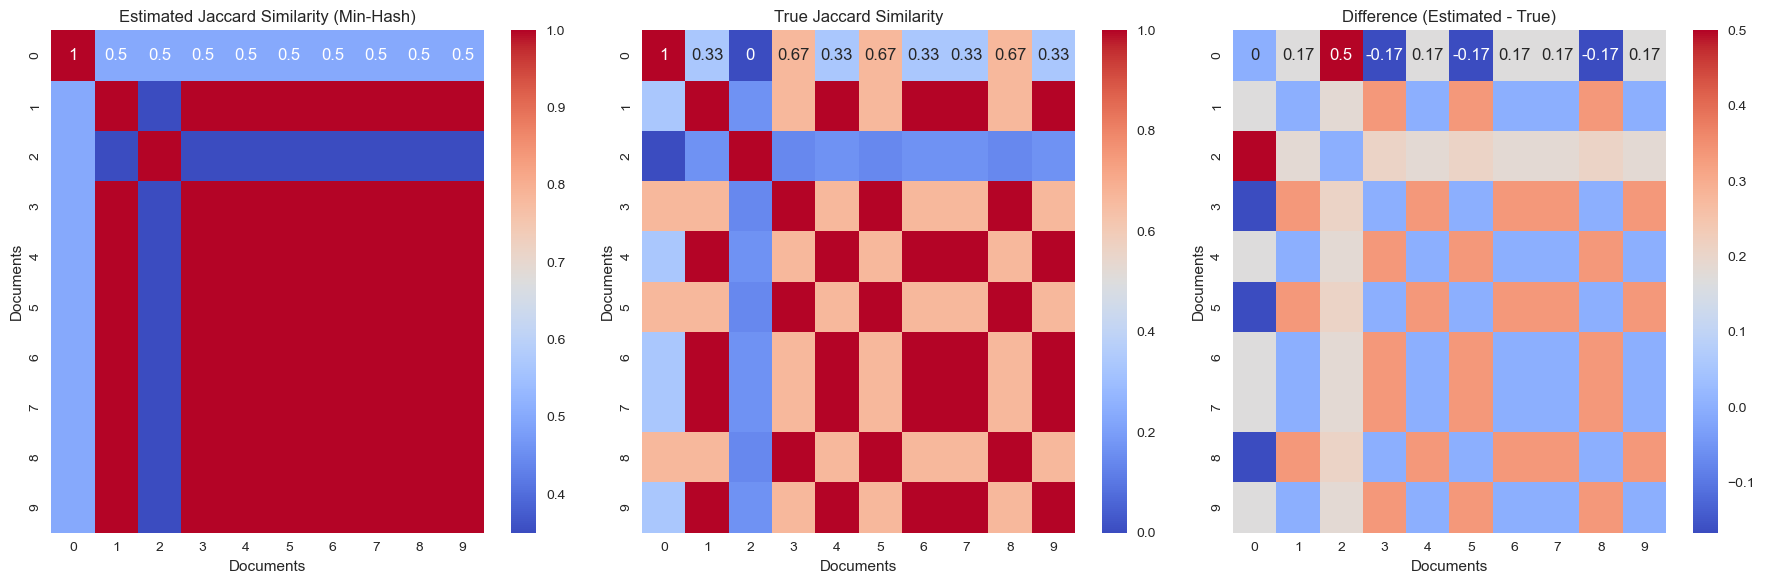

In [134]:
# Difference Matrix
difference_matrix = estimated_similarities - true_similarities

# Plotting the heatmaps
plt.figure(figsize=(18, 6))

# Estimated Jaccard Similarity Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(estimated_similarities, annot=True, cmap='coolwarm', cbar=True)
plt.title('Estimated Jaccard Similarity (Min-Hash)')
plt.xlabel('Documents')
plt.ylabel('Documents')

# True Jaccard Similarity Heatmap
plt.subplot(1, 3, 2)
sns.heatmap(true_similarities, annot=True, cmap='coolwarm', cbar=True)
plt.title('True Jaccard Similarity')
plt.xlabel('Documents')
plt.ylabel('Documents')

# Difference Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(difference_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Difference (Estimated - True)')
plt.xlabel('Documents')
plt.ylabel('Documents')

# Show the plots
plt.tight_layout()
plt.show()

### Look at NN accuracy

In [135]:
def find_nearest_neighbor(similarity_matrix):
    nearest_neighbors = np.argmin(similarity_matrix, axis=1)
    return nearest_neighbors

# Find nearest neighbors based on estimated and true similarities
estimated_nn = find_nearest_neighbor(estimated_similarities)
true_nn = find_nearest_neighbor(true_similarities)

print("Estimated Nearest Neighbors:", estimated_nn)
print("True Nearest Neighbors:", true_nn)

# Compute the accuracy of nearest neighbors
matching_nn = np.sum(estimated_nn == true_nn)
total_nn = len(estimated_nn)
accuracy = matching_nn / total_nn

accuracy

Estimated Nearest Neighbors: [1 2 1 2 2 2 2 2 2 2]
True Nearest Neighbors: [2 2 0 2 2 2 2 2 2 2]


0.8

## Testing on various bucket sizes

In [154]:
num_hashes_list = [2, 4, 8, 12, 16, 20]  # Number of hash functions
difference_matrices = []
accuracies = []

for num_hashes in num_hashes_list:
    start = time.time()
    hash_functions = [
        (random.randint(1, max_int), random.randint(0, max_int)) for _ in range(num_hashes)
    ]

    min_hash_signatures = np.full((num_hashes, num_docs), max_int)

    for i, (a, b) in enumerate(hash_functions):
        for r in range(num_rows):
            hash_value = hash_func(a, b, r)
            min_hash_signatures[i, bin_mat[r] == 1] = np.minimum(min_hash_signatures[i, bin_mat[r] == 1], hash_value)



    # Calculate pairwise estimated Jaccard similarity for sampled documents
    estimated_similarities = np.zeros((len(sampled_docs), len(sampled_docs)))

    for i in range(len(sampled_docs)):
        for j in range(len(sampled_docs)):
            estimated_similarities[i, j] = estimated_jaccard_similarity(min_hash_signatures, sampled_docs[i], sampled_docs[j])
    

    # Calculate pairwise true Jaccard similarity for sampled documents
    true_similarities = np.zeros((len(sampled_docs), len(sampled_docs)))

    for i in range(len(sampled_docs)):
        for j in range(len(sampled_docs)):
            true_similarities[i, j] = true_jaccard_similarity(gram_df, sampled_docs[i], sampled_docs[j])


    # Difference Matrix
    difference_matrix = estimated_similarities - true_similarities
    difference_matrices.append(difference_matrix)



    # Find nearest neighbors based on estimated and true similarities
    estimated_nn = find_nearest_neighbor(estimated_similarities)
    true_nn = find_nearest_neighbor(true_similarities)

    # Compute the accuracy of nearest neighbors
    matching_nn = np.sum(estimated_nn == true_nn)
    total_nn = len(estimated_nn)
    accuracy = matching_nn / total_nn
    accuracies.append(accuracy)

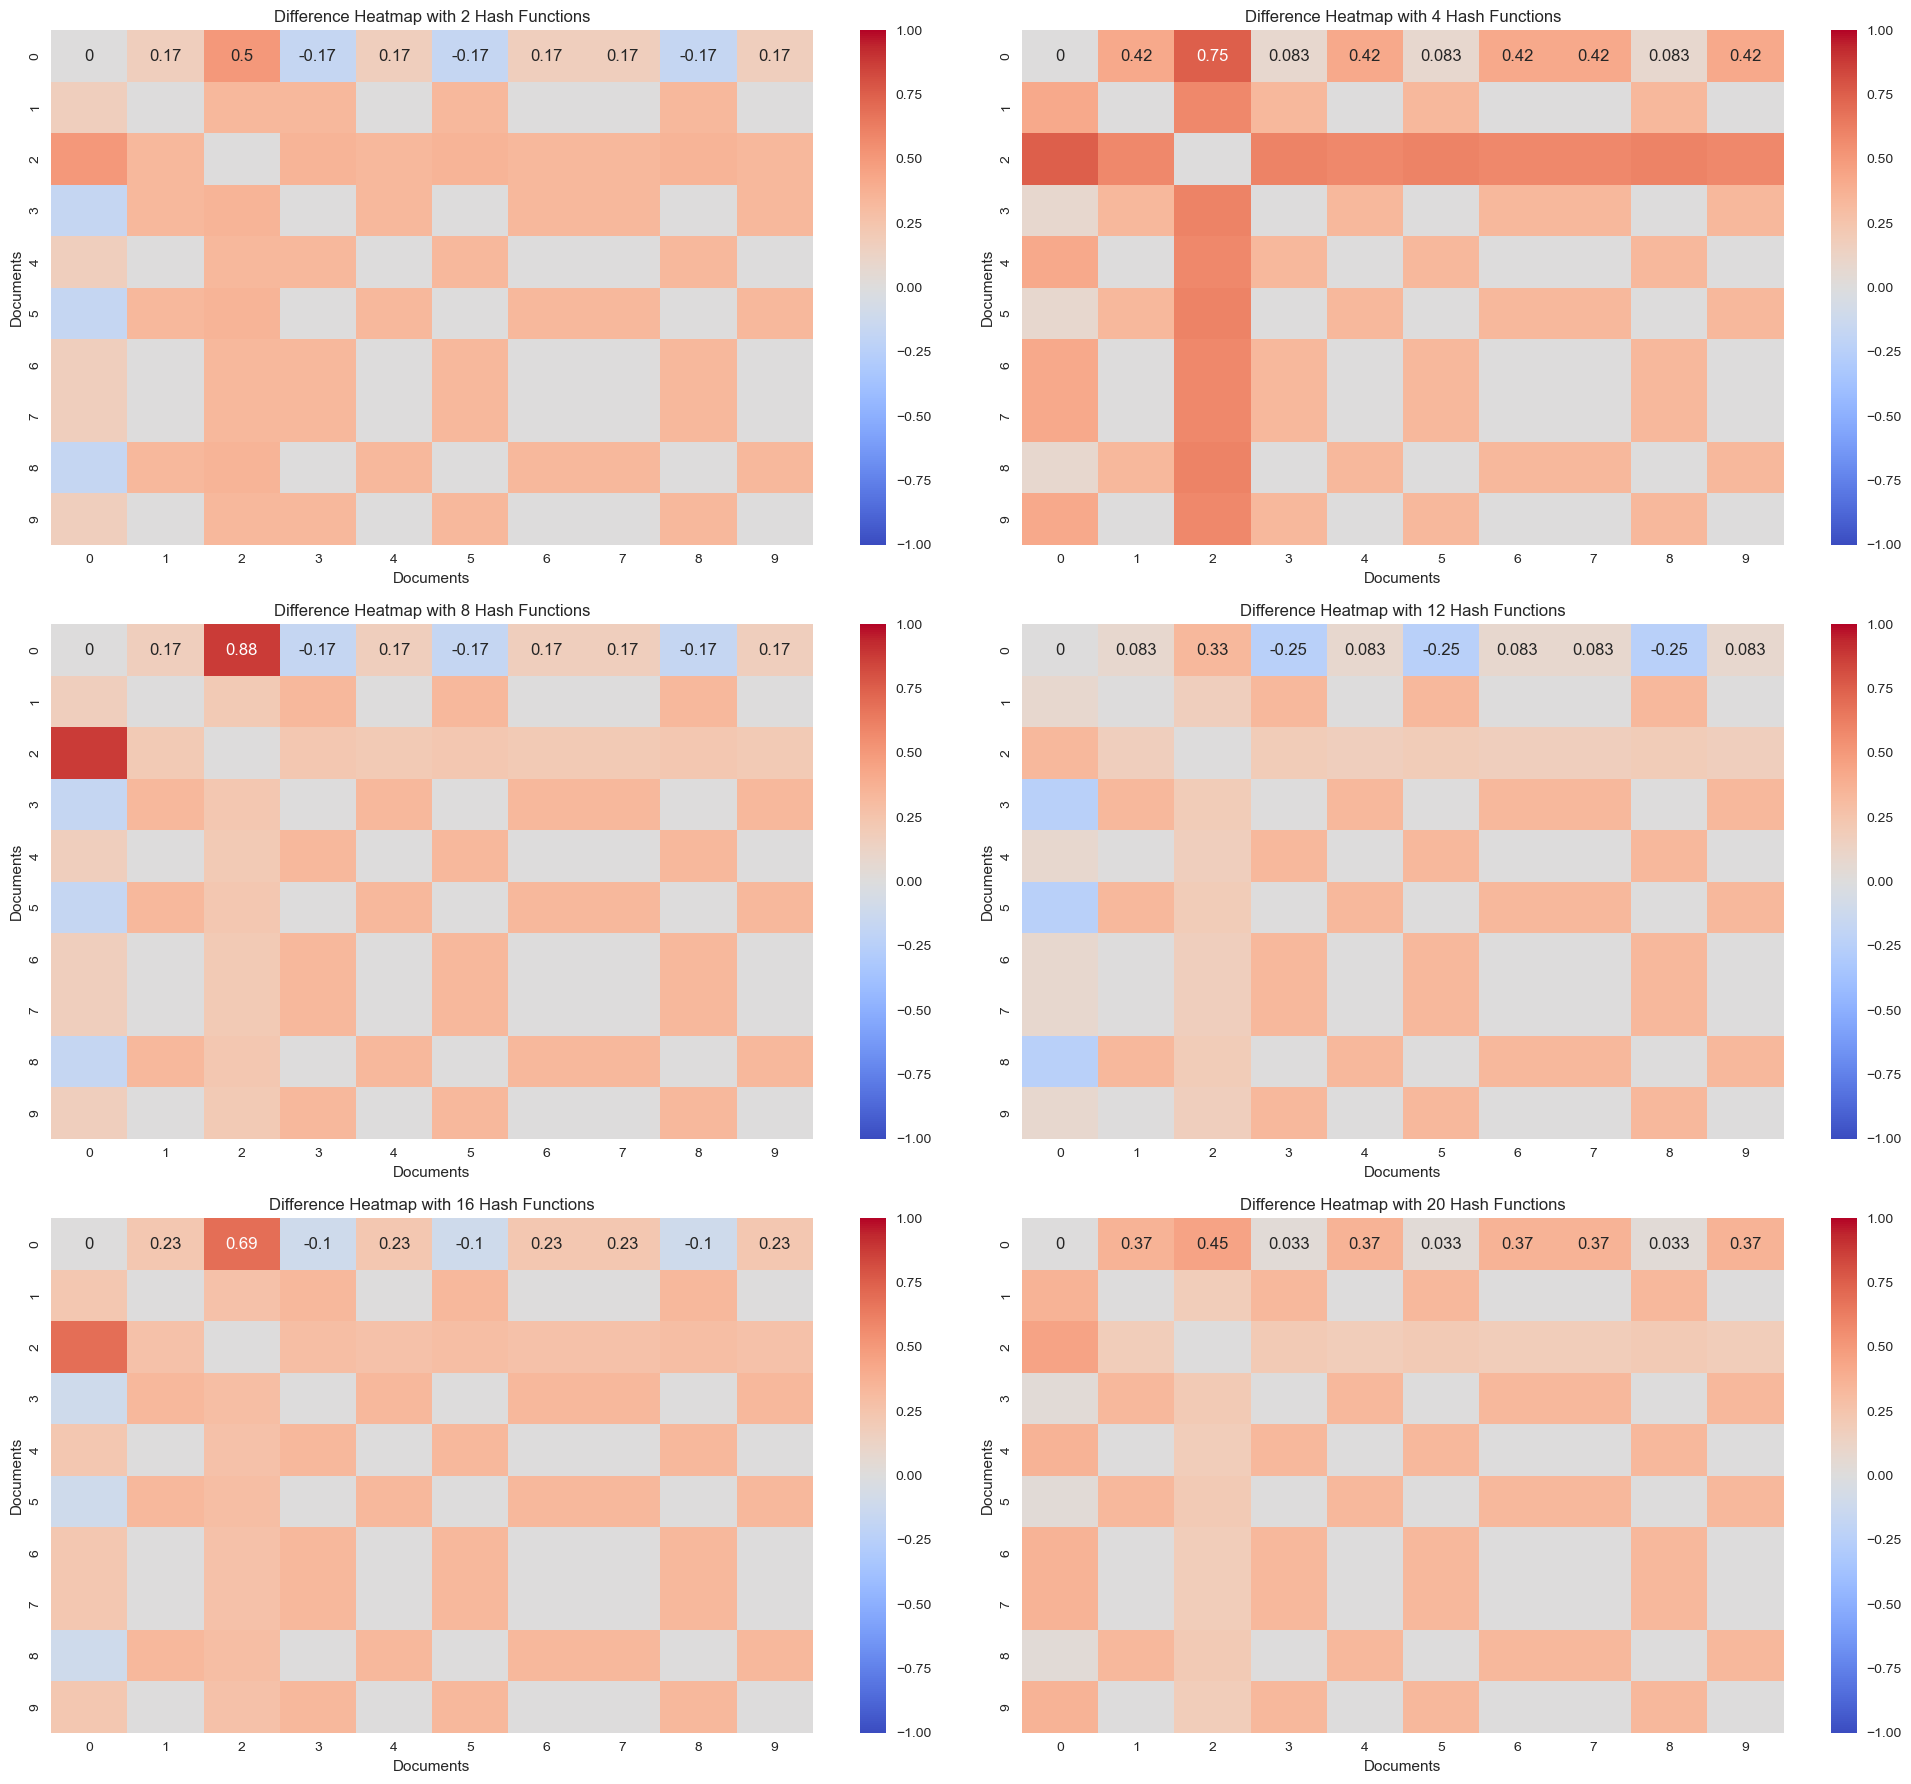

In [155]:
# Plotting the heatmaps
n = len(num_hashes_list)
plt.figure(figsize=(20, 3*n))

for idx, num_hashes in enumerate(num_hashes_list):
    plt.subplot(3, 2, idx + 1)
    sns.heatmap(difference_matrices[idx], annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
    plt.title(f'Difference Heatmap with {num_hashes} Hash Functions')
    plt.xlabel('Documents')
    plt.ylabel('Documents')

plt.tight_layout()
plt.show()

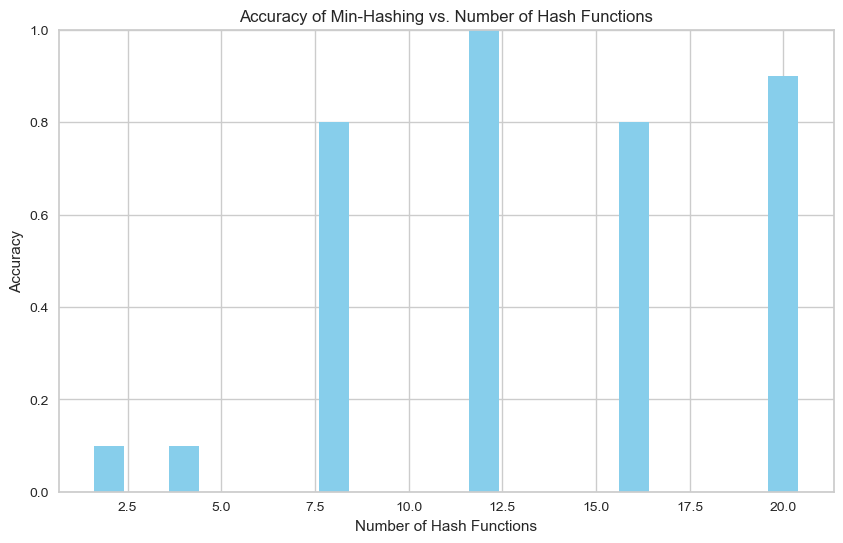

In [157]:
plt.figure(figsize=(10, 6))
plt.bar(num_hashes_list, accuracies, color='skyblue')
plt.xlabel('Number of Hash Functions')
plt.ylabel('Accuracy')
plt.title('Accuracy of Min-Hashing vs. Number of Hash Functions')
plt.ylim(0, 1)
plt.show()

### Time complexity
- Run at your own peril

In [169]:
# Calculate pairwise estimated Jaccard similarity for sampled documents
estimated_similarities = np.zeros((num_docs, num_docs))
print(min_hash_signatures.shape)

start = time.time()
for i in range(num_docs//100):
        for j in range(num_docs//100):
            estimated_similarities[i, j] = estimated_jaccard_similarity(min_hash_signatures, i, j)
end = time.time()
print("Time taken for Min-Hashing:", end - start)

(20, 122199)
Time taken for Min-Hashing: 7.59709906578064


In [170]:
true_similarities = np.zeros((num_docs, num_docs))

start = time.time()
for i in range(num_docs//100):
    for j in range(num_docs//100):
        true_similarities[i, j] = true_jaccard_similarity(gram_df, i, j)

end = time.time()
print("Time taken for True Jaccard Similarity:", end - start)

Time taken for True Jaccard Similarity: 562.7939190864563


### 3b. Analysis and answers to the questions

First thing to note is that min-wise locality sensitive hashing (ming hashing) is performed on very LARGE documents, from which millions to billions of shingles are extracted, forming the need to use approximations. In our case, we only have 20 shingles from a 3-gram where the values range from [0..2].

What results do we get?
- Using a greater signature by having more hash functions gives us more accuracy on predicting the nearest neighbor, however, the returns diminish after a certain signature size.
- Performance: Min-hashing achieves very high accuracies, for example getting 1.0 for 12 neighbors.
- Runtime: unfortunately, calculating pairwise neighbor distances takes a very long time for both, although not surprising given this task has quadratic time complexity. It takes 8 seconds for the minhash to get the jaccard indices, while taking the true values takes over 9 minutes. this is done on 1% of the data.
- Space: Neither use a lot of memory, although in this scenario the signature size is actually larger than the feature space. So in this scenario there are basically no benefits to minhashing.

As mentioned in the beginning of my analysis, the amount of shingles here is tiny, so minhashing actually _increases_ the feature space! I would not recommend this in theory, but the results show that this improves time performance drastically, so I would actually recommend it, even with a large number of hashes/bins for better accuracy.

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### Scenario 9

#### 4a. Learn a sequential model, profiling and fingerprinting

In [312]:
data = pd.read_csv("cda-lab3-botnet-detection/dataset_9/capture20110817.binetflow")
preprocessed_data = preprocess_data(data, date_fix=True, remove_background=False, label_enc=True, label_enc_columns=['Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos'])
discr_data = discretize_data(preprocessed_data, ['Proto', 'Dir'], [3, 2])

In [313]:
discr_data['Combined'] = attribute_mappings(discr_data, ['Dir', 'Proto'])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Combined
0,2011-08-17 12:01:12.984851,0.976560,2,93.45.141.223,13827,1,147.32.84.118,46153,226,0,0,4,244,124,0,5.0
1,2011-08-17 12:01:15.616709,0.950668,2,84.16.60.37,59624,1,147.32.84.118,46153,226,0,0,4,244,124,0,5.0
2,2011-08-17 12:01:23.209772,1.006908,2,94.44.197.227,31309,1,147.32.84.118,46153,226,0,0,4,276,156,0,5.0
3,2011-08-17 12:01:24.216680,1.000400,2,94.44.197.227,31309,1,147.32.84.118,46153,226,0,0,4,276,156,0,5.0
4,2011-08-17 12:03:27.216922,1.093291,2,147.32.3.51,7238,1,147.32.87.22,6630,226,0,0,4,244,124,0,5.0


In [314]:
# keep unique values for combined discretized feature
SYMBOLS = discr_data['Combined'].unique()
SYMBOLS

array([5., 0., 2., 3., 4., 1.])

In [315]:
# keep source addresses and labels
ips_with_labels = discr_data[['SrcAddr', 'Label']].groupby(by='SrcAddr').max()
ips_with_labels = ips_with_labels.reset_index()
ips_with_labels

,SrcAddr,Label
0,0.0.0.0,0
1,00:00:00:00:00:00,0
2,00:0c:29:97:a3:eb,0
3,00:15:17:2c:e5:2d,0
4,1.112.101.248,0
...,...,...
313761,fe80::5054:ff:fe89:354,0
313762,fe80::5054:ff:feef:6697,0
313763,fe80::7272:cfff:fe1b:d243,0
313764,fe80::d036:46ef:ad35:fc09,0


In [316]:
# separate infected and benign IPs
infected_ips = ips_with_labels[ips_with_labels.Label == "1"]['SrcAddr'].to_list()
benign_ips = ips_with_labels[ips_with_labels.Label == "0"]['SrcAddr'].to_list()

# print the number of infected and benign IPs
len(infected_ips), len(benign_ips)

(10, 313756)

In [317]:
# signature generator for a single IP
def gen_signature(host_data, host_ip, is_train=True):
    
    # dict for host IP signature
    signature = {}
    signature[host_ip] = {}
    
    # data contain: IP, Label, Combined feature (Proto-Direction)
    # renaming for FlexFringe
    flex_data = host_data[['SrcAddr', 'Label', 'Combined']]
    flex_data = flex_data.rename(columns={
        'SrcAddr': 'id',
        'Label': 'type',
        'Combined': 'symb'
    })
    flex_data.to_csv('flex_fringe_files/flex_trace.csv', index=None)
    
    # train mode
    # train FlexFringe on the data to get a signature/ states-transition counts
    if is_train:
        FLEXFRINGE = FlexFringe(
            flexfringe_path="./flexfringe-x64-windows.exe",
            heuristic_name="alergia",
            data_name="alergia_data",
            slidingwindow=1,
            swsize=10
        )
        # Learn a state machine
        FLEXFRINGE.fit('./flex_fringe_files/flex_trace.csv')
    
    else:
        # Use state machine to predict likelihoods
        df = FLEXFRINGE.predict('flex_fringe_files/flex_trace.csv')
        return df
    
  
    # get results from FlexFringe training
    results = None  
    with open('flex_fringe_files/flex_trace.csv.ff.final.json') as f:
        results = json.load(f)
    
    # for every state-symbol combination, compute transition counts
    # and create the profile for this host IP
    for node in results['nodes']:
        # initialize the state-symbol combination
        for symbol in SYMBOLS:
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] = 0.0
            
        # update the state-symbol combination with the transition counts
        for symbol in node['data']['trans_counts'].keys():
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] += int(node['data']['trans_counts'][symbol])
            
    return pd.DataFrame(signature).T

In [320]:
# get first infected host, create its signature
infected_host_sample = discr_data[discr_data.SrcAddr == infected_ips[0]]
print("Infected host IP: ",infected_ips[0])


ref_signature = gen_signature(infected_host_sample, infected_ips[0], is_train=True)
ref_signature = ref_signature.rename_axis('SrcAddr').reset_index()

Infected host IP:  147.32.84.165


In [321]:
# check signature
ref_signature

,SrcAddr,-1_5.0,-1_0.0,-1_2.0,-1_3.0,-1_4.0,-1_1.0,1_5.0,1_0.0,1_2.0,1_3.0,1_4.0,1_1.0,41_5.0,41_0.0,41_2.0,41_3.0,41_4.0,41_1.0,50_5.0,50_0.0,50_2.0,50_3.0,50_4.0,50_1.0,51_5.0,51_0.0,51_2.0,51_3.0,51_4.0,51_1.0,52_5.0,52_0.0,52_2.0,52_3.0,52_4.0,52_1.0,661_5.0,661_0.0,661_2.0,661_3.0,661_4.0,661_1.0,53_5.0,53_0.0,53_2.0,53_3.0,53_4.0,53_1.0
0,147.32.84.165,1633.0,3169.0,0.0,3.0,1.0,0.0,7146.0,20527.0,0.0,16.0,5.0,0.0,3259.0,3106.0,0.0,0.0,2.0,0.0,2185.0,2286.0,0.0,1.0,0.0,0.0,941.0,1142.0,0.0,2.0,0.0,0.0,413.0,438.0,0.0,4.0,1.0,0.0,112.0,519.0,0.0,0.0,0.0,0.0,552.0,275.0,0.0,1.0,1.0,0.0


In [322]:
# Initialize the signatures DataFrame - for all hosts
signatures = pd.DataFrame()

# Function to collect signatures and labels
def collect_signatures(ips, label):
    global signatures
    # for every IP in the list,
    # generate signature and save it, with label
    for ip in ips:
        host_data = discr_data[discr_data.SrcAddr == ip]
        signature = gen_signature(host_data, ip)
        signature = signature.fillna(0)
        signature['label'] = label
        signatures = pd.concat([signatures, signature])

In [323]:
# NOTE: we keep only the first 1000 benign IPs for computational reasons
# This cell may take around 5 minutes to run
# Adjust number of benign IPs accordingly

# Collect signatures for infected and benign hosts
collect_signatures(infected_ips, 1)
collect_signatures(benign_ips[:1000], 0)

# Save to re-use, if necessary
# signatures = signatures.dropna(axis=1)

# replace na with 0 across axis 1
signatures = signatures.fillna(0)

test_df = signatures.rename_axis('SrcAddr').reset_index()
test_df.to_csv('flex_fringe_files/dataset_9/signatures.csv', index=None)

In [324]:
test_df

,SrcAddr,-1_5.0,-1_0.0,-1_2.0,-1_3.0,-1_4.0,-1_1.0,1_5.0,1_0.0,1_2.0,1_3.0,1_4.0,1_1.0,41_5.0,41_0.0,41_2.0,41_3.0,41_4.0,41_1.0,50_5.0,50_0.0,50_2.0,50_3.0,50_4.0,50_1.0,51_5.0,51_0.0,51_2.0,51_3.0,51_4.0,51_1.0,52_5.0,52_0.0,52_2.0,52_3.0,52_4.0,52_1.0,661_5.0,661_0.0,661_2.0,661_3.0,661_4.0,661_1.0,53_5.0,53_0.0,53_2.0,53_3.0,53_4.0,53_1.0,label,30_5.0,30_0.0,30_2.0,30_3.0,30_4.0,30_1.0,31_5.0,31_0.0,31_2.0,31_3.0,31_4.0,31_1.0,11_5.0,11_0.0,11_2.0,11_3.0,11_4.0,11_1.0,2_5.0,2_0.0,2_2.0,2_3.0,2_4.0,2_1.0,12_5.0,12_0.0,12_2.0,12_3.0,12_4.0,12_1.0,3_5.0,3_0.0,3_2.0,3_3.0,3_4.0,3_1.0,13_5.0,13_0.0,13_2.0,13_3.0,13_4.0,13_1.0,4_5.0,4_0.0,4_2.0,4_3.0,4_4.0,4_1.0,14_5.0,14_0.0,14_2.0,14_3.0,14_4.0,14_1.0,21_5.0,21_0.0,21_2.0,21_3.0,21_4.0,21_1.0,22_5.0,22_0.0,22_2.0,22_3.0,22_4.0,22_1.0,113_5.0,113_0.0,113_2.0,113_3.0,113_4.0,113_1.0,114_5.0,114_0.0,114_2.0,114_3.0,114_4.0,114_1.0,115_5.0,115_0.0,115_2.0,115_3.0,115_4.0,115_1.0,48_5.0,48_0.0,48_2.0,48_3.0,48_4.0,48_1.0,49_5.0,49_0.0,49_2.0,49_3.0,49_4.0,49_1.0,60_5.0,60_0.0,60_2.0,60_3.0,60_4.0,60_1.0,57_5.0,57_0.0,57_2.0,57_3.0,57_4.0,57_1.0,89_5.0,89_0.0,89_2.0,89_3.0,89_4.0,89_1.0,90_5.0,90_0.0,90_2.0,90_3.0,90_4.0,90_1.0,404_5.0,404_0.0,404_2.0,404_3.0,404_4.0,404_1.0,91_5.0,91_0.0,91_2.0,91_3.0,91_4.0,91_1.0,42_5.0,42_0.0,42_2.0,42_3.0,42_4.0,42_1.0,228_5.0,228_0.0,228_2.0,228_3.0,228_4.0,228_1.0,39_5.0,39_0.0,39_2.0,39_3.0,39_4.0,39_1.0,107_5.0,107_0.0,107_2.0,107_3.0,107_4.0,107_1.0,36_5.0,36_0.0,36_2.0,36_3.0,36_4.0,36_1.0,45_5.0,45_0.0,45_2.0,45_3.0,45_4.0,45_1.0,37_5.0,37_0.0,37_2.0,37_3.0,37_4.0,37_1.0,417_5.0,417_0.0,417_2.0,417_3.0,417_4.0,417_1.0,82_5.0,82_0.0,82_2.0,82_3.0,82_4.0,82_1.0,83_5.0,83_0.0,83_2.0,83_3.0,83_4.0,83_1.0,84_5.0,84_0.0,84_2.0,84_3.0,84_4.0,84_1.0,71_5.0,71_0.0,71_2.0,71_3.0,71_4.0,71_1.0,23_5.0,23_0.0,23_2.0,23_3.0,23_4.0,23_1.0
0,147.32.84.165,1633.0,3169.0,0.0,3.0,1.0,0.0,7146.0,20527.0,0.0,16.0,5.0,0.0,3259.0,3106.0,0.0,0.0,2.0,0.0,2185.0,2286.0,0.0,1.0,0.0,0.0,941.0,1142.0,0.0,2.0,0.0,0.0,413.0,438.0,0.0,4.0,1.0,0.0,112.0,519.0,0.0,0.0,0.0,0.0,552.0,275.0,0.0,1.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,147.32.84.191,1604.0,2350.0,0.0,4.0,2.0,0.0,4459.0,10790.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8276.0,6259.0,0.0,5.0,4.0,0.0,1792.0,3759.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [325]:
signatures

,-1_5.0,-1_0.0,-1_2.0,-1_3.0,-1_4.0,-1_1.0,1_5.0,1_0.0,1_2.0,1_3.0,1_4.0,1_1.0,41_5.0,41_0.0,41_2.0,41_3.0,41_4.0,41_1.0,50_5.0,50_0.0,50_2.0,50_3.0,50_4.0,50_1.0,51_5.0,51_0.0,51_2.0,51_3.0,51_4.0,51_1.0,52_5.0,52_0.0,52_2.0,52_3.0,52_4.0,52_1.0,661_5.0,661_0.0,661_2.0,661_3.0,661_4.0,661_1.0,53_5.0,53_0.0,53_2.0,53_3.0,53_4.0,53_1.0,label,30_5.0,30_0.0,30_2.0,30_3.0,30_4.0,30_1.0,31_5.0,31_0.0,31_2.0,31_3.0,31_4.0,31_1.0,11_5.0,11_0.0,11_2.0,11_3.0,11_4.0,11_1.0,2_5.0,2_0.0,2_2.0,2_3.0,2_4.0,2_1.0,12_5.0,12_0.0,12_2.0,12_3.0,12_4.0,12_1.0,3_5.0,3_0.0,3_2.0,3_3.0,3_4.0,3_1.0,13_5.0,13_0.0,13_2.0,13_3.0,13_4.0,13_1.0,4_5.0,4_0.0,4_2.0,4_3.0,4_4.0,4_1.0,14_5.0,14_0.0,14_2.0,14_3.0,14_4.0,14_1.0,21_5.0,21_0.0,21_2.0,21_3.0,21_4.0,21_1.0,22_5.0,22_0.0,22_2.0,22_3.0,22_4.0,22_1.0,113_5.0,113_0.0,113_2.0,113_3.0,113_4.0,113_1.0,114_5.0,114_0.0,114_2.0,114_3.0,114_4.0,114_1.0,115_5.0,115_0.0,115_2.0,115_3.0,115_4.0,115_1.0,48_5.0,48_0.0,48_2.0,48_3.0,48_4.0,48_1.0,49_5.0,49_0.0,49_2.0,49_3.0,49_4.0,49_1.0,60_5.0,60_0.0,60_2.0,60_3.0,60_4.0,60_1.0,57_5.0,57_0.0,57_2.0,57_3.0,57_4.0,57_1.0,89_5.0,89_0.0,89_2.0,89_3.0,89_4.0,89_1.0,90_5.0,90_0.0,90_2.0,90_3.0,90_4.0,90_1.0,404_5.0,404_0.0,404_2.0,404_3.0,404_4.0,404_1.0,91_5.0,91_0.0,91_2.0,91_3.0,91_4.0,91_1.0,42_5.0,42_0.0,42_2.0,42_3.0,42_4.0,42_1.0,228_5.0,228_0.0,228_2.0,228_3.0,228_4.0,228_1.0,39_5.0,39_0.0,39_2.0,39_3.0,39_4.0,39_1.0,107_5.0,107_0.0,107_2.0,107_3.0,107_4.0,107_1.0,36_5.0,36_0.0,36_2.0,36_3.0,36_4.0,36_1.0,45_5.0,45_0.0,45_2.0,45_3.0,45_4.0,45_1.0,37_5.0,37_0.0,37_2.0,37_3.0,37_4.0,37_1.0,417_5.0,417_0.0,417_2.0,417_3.0,417_4.0,417_1.0,82_5.0,82_0.0,82_2.0,82_3.0,82_4.0,82_1.0,83_5.0,83_0.0,83_2.0,83_3.0,83_4.0,83_1.0,84_5.0,84_0.0,84_2.0,84_3.0,84_4.0,84_1.0,71_5.0,71_0.0,71_2.0,71_3.0,71_4.0,71_1.0,23_5.0,23_0.0,23_2.0,23_3.0,23_4.0,23_1.0
147.32.84.165,1633.0,3169.0,0.0,3.0,1.0,0.0,7146.0,20527.0,0.0,16.0,5.0,0.0,3259.0,3106.0,0.0,0.0,2.0,0.0,2185.0,2286.0,0.0,1.0,0.0,0.0,941.0,1142.0,0.0,2.0,0.0,0.0,413.0,438.0,0.0,4.0,1.0,0.0,112.0,519.0,0.0,0.0,0.0,0.0,552.0,275.0,0.0,1.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147.32.84.191,1604.0,2350.0,0.0,4.0,2.0,0.0,4459.0,10790.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8276.0,6259.0,0.0,5.0,4.0,0.0,1792.0,3759.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [326]:
# Extract the relevant columns (last 4 columns in this case)
features = signatures.drop('label', axis=1)

# Calculate cosine similarity
cos_sim = cosine_similarity(features)

# Convert cosine similarity to cosine distance
cos_dist = 1-cos_sim

# Display the cosine distances between the selected infected host and all others
first_row_distances = cos_dist[0]
print("Cosine distances from selected infected host to all other hosts:")
print(first_row_distances)

Cosine distances from selected infected host to all other hosts:
[1.11022302e-16 2.95284871e-01 6.33278509e-01 ... 8.60844749e-01
 8.60844749e-01 8.60844749e-01]


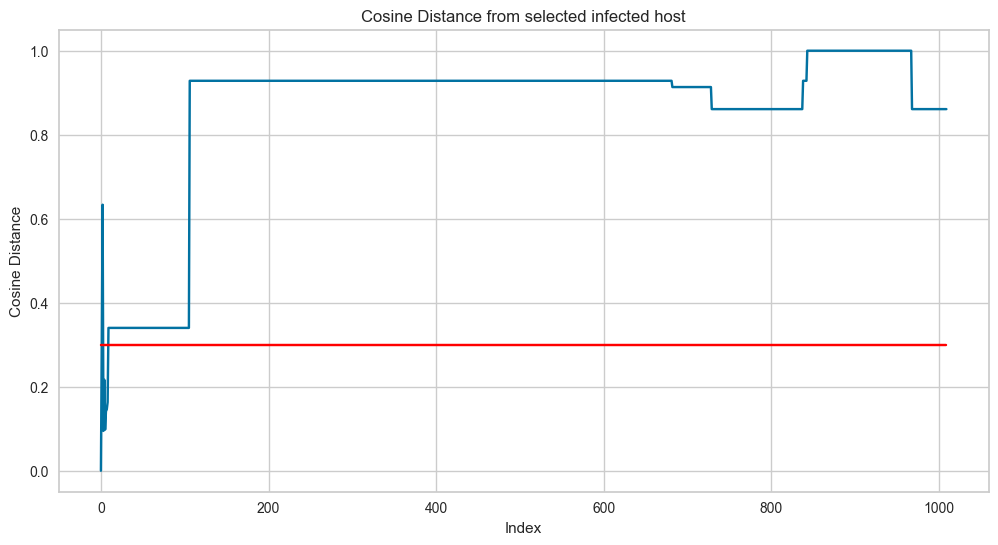

In [373]:
# plot cosine distance vs row number
plt.figure(figsize=(12, 6))
plt.plot(first_row_distances)
plt.plot(range(len(first_row_distances)), np.array([0.3] * len(first_row_distances)), label='threshold', color='red')
plt.title('Cosine Distance from selected infected host')
plt.xlabel('Index')
plt.ylabel('Cosine Distance')
plt.show()

In [336]:
# make predictions based on threshold
predictions = np.array(first_row_distances.reshape(-1) < 0.3).astype(int)
test_df['predictions'] = predictions

# confusion matrix of predictions and infections
confusion_matrix(np.array(test_df.label), np.array(test_df.predictions))

array([[1000,    0],
       [   2,    8]], dtype=int64)

In [461]:
# find expected values for each state-symbol combination
expectations = features.mean()
expectations[:20]

-1_5.0     24.403370
-1_2.0      0.285431
-1_0.0     30.706640
-1_3.0     13.084242
-1_4.0      0.025768
-1_1.0      0.000000
38_5.0      0.089197
38_2.0      0.000000
38_0.0      0.065411
38_3.0      0.008920
38_4.0      0.005946
38_1.0      0.000000
228_5.0     0.001982
228_2.0     0.000000
228_0.0     0.194252
228_3.0     0.274529
228_4.0     0.000000
228_1.0     0.000000
20_5.0      0.126858
20_2.0      0.000000
dtype: float64

In [338]:
test_df[:20]

,SrcAddr,-1_5.0,-1_0.0,-1_2.0,-1_3.0,-1_4.0,-1_1.0,1_5.0,1_0.0,1_2.0,1_3.0,1_4.0,1_1.0,41_5.0,41_0.0,41_2.0,41_3.0,41_4.0,41_1.0,50_5.0,50_0.0,50_2.0,50_3.0,50_4.0,50_1.0,51_5.0,51_0.0,51_2.0,51_3.0,51_4.0,51_1.0,52_5.0,52_0.0,52_2.0,52_3.0,52_4.0,52_1.0,661_5.0,661_0.0,661_2.0,661_3.0,661_4.0,661_1.0,53_5.0,53_0.0,53_2.0,53_3.0,53_4.0,53_1.0,label,30_5.0,30_0.0,30_2.0,30_3.0,30_4.0,30_1.0,31_5.0,31_0.0,31_2.0,31_3.0,31_4.0,31_1.0,11_5.0,11_0.0,11_2.0,11_3.0,11_4.0,11_1.0,2_5.0,2_0.0,2_2.0,2_3.0,2_4.0,2_1.0,12_5.0,12_0.0,12_2.0,12_3.0,12_4.0,12_1.0,3_5.0,3_0.0,3_2.0,3_3.0,3_4.0,3_1.0,13_5.0,13_0.0,13_2.0,13_3.0,13_4.0,13_1.0,4_5.0,4_0.0,4_2.0,4_3.0,4_4.0,4_1.0,14_5.0,14_0.0,14_2.0,14_3.0,14_4.0,14_1.0,21_5.0,21_0.0,21_2.0,21_3.0,21_4.0,21_1.0,22_5.0,22_0.0,22_2.0,22_3.0,22_4.0,22_1.0,113_5.0,113_0.0,113_2.0,113_3.0,113_4.0,113_1.0,114_5.0,114_0.0,114_2.0,114_3.0,114_4.0,114_1.0,115_5.0,115_0.0,115_2.0,115_3.0,115_4.0,115_1.0,48_5.0,48_0.0,48_2.0,48_3.0,48_4.0,48_1.0,49_5.0,49_0.0,49_2.0,49_3.0,49_4.0,49_1.0,60_5.0,60_0.0,60_2.0,60_3.0,60_4.0,60_1.0,57_5.0,57_0.0,57_2.0,57_3.0,57_4.0,57_1.0,89_5.0,89_0.0,89_2.0,89_3.0,89_4.0,89_1.0,90_5.0,90_0.0,90_2.0,90_3.0,90_4.0,90_1.0,404_5.0,404_0.0,404_2.0,404_3.0,404_4.0,404_1.0,91_5.0,91_0.0,91_2.0,91_3.0,91_4.0,91_1.0,42_5.0,42_0.0,42_2.0,42_3.0,42_4.0,42_1.0,228_5.0,228_0.0,228_2.0,228_3.0,228_4.0,228_1.0,39_5.0,39_0.0,39_2.0,39_3.0,39_4.0,39_1.0,107_5.0,107_0.0,107_2.0,107_3.0,107_4.0,107_1.0,36_5.0,36_0.0,36_2.0,36_3.0,36_4.0,36_1.0,45_5.0,45_0.0,45_2.0,45_3.0,45_4.0,45_1.0,37_5.0,37_0.0,37_2.0,37_3.0,37_4.0,37_1.0,417_5.0,417_0.0,417_2.0,417_3.0,417_4.0,417_1.0,82_5.0,82_0.0,82_2.0,82_3.0,82_4.0,82_1.0,83_5.0,83_0.0,83_2.0,83_3.0,83_4.0,83_1.0,84_5.0,84_0.0,84_2.0,84_3.0,84_4.0,84_1.0,71_5.0,71_0.0,71_2.0,71_3.0,71_4.0,71_1.0,23_5.0,23_0.0,23_2.0,23_3.0,23_4.0,23_1.0,predictions
0,147.32.84.165,1633.0,3169.0,0.0,3.0,1.0,0.0,7146.0,20527.0,0.0,16.0,5.0,0.0,3259.0,3106.0,0.0,0.0,2.0,0.0,2185.0,2286.0,0.0,1.0,0.0,0.0,941.0,1142.0,0.0,2.0,0.0,0.0,413.0,438.0,0.0,4.0,1.0,0.0,112.0,519.0,0.0,0.0,0.0,0.0,552.0,275.0,0.0,1.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,147.32.84.191,1604.0,2350.0,0.0,4.0,2.0,0.0,4459.0,10790.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8276.0,6259.0,0.0,5.0,4.0,0.0,1792.0,3759.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [347]:
print(features)

                 -1_5.0  -1_0.0  -1_2.0  -1_3.0  -1_4.0  -1_1.0   1_5.0  \
147.32.84.165    1633.0  3169.0     0.0     3.0     1.0     0.0  7146.0   
147.32.84.191    1604.0  2350.0     0.0     4.0     2.0     0.0  4459.0   
147.32.84.192    1899.0  2376.0     0.0     7.0     0.0     0.0  2022.0   
147.32.84.193    1643.0  2474.0     0.0     8.0     0.0     0.0  4622.0   
147.32.84.204    1748.0  2199.0     0.0     2.0     0.0     0.0  5231.0   
...                 ...     ...     ...     ...     ...     ...     ...   
101.108.99.182      0.0    20.0     0.0     0.0     0.0     0.0     0.0   
101.108.99.40       0.0    20.0     0.0     0.0     0.0     0.0     0.0   
101.109.1.65        0.0    20.0     0.0     0.0     0.0     0.0     0.0   
101.109.101.223     0.0    20.0     0.0     0.0     0.0     0.0     0.0   
101.109.107.110     0.0    20.0     0.0     0.0     0.0     0.0     0.0   

                   1_0.0  1_2.0  1_3.0  1_4.0  1_1.0  41_5.0  41_0.0  41_2.0  \
147.32.84.165    20

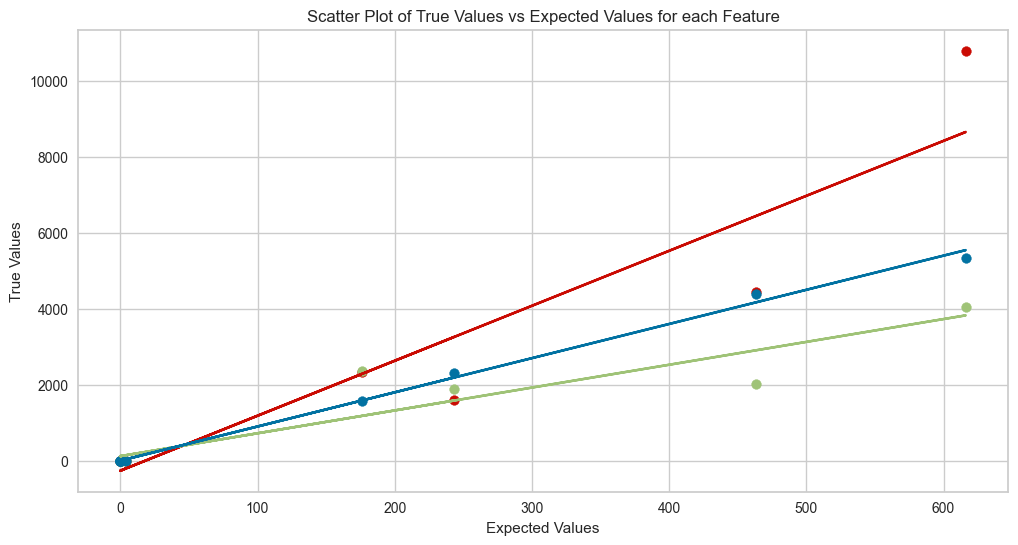

RED LINE: TRUE POSITIVE
GREEN LINE: FALSE NEGATIVE
BLUE LINE: TRUE NEGATIVE


In [372]:
true_positive_ip = "147.32.84.191"
false_negative_ip = "147.32.84.192"
true_negative_ip = "1.112.147.98"

ips_plot = [true_positive_ip, false_negative_ip, true_negative_ip]

plot_df = test_df[test_df['SrcAddr'].isin(ips_plot)]

# Plot the scatter plot
plt.figure(figsize=(12, 6))

# Define a color list for each IP
colors = ['r', 'g', 'b']

# Iterate over each feature
for i, ip in enumerate(ips_plot):
    for f in features.columns[:10]:
        if f != 'SrcAddr':  # Exclude the 'SrcAddr' column
            # Plot the expected value of the feature on x-axis and true values on y-axis
            plt.scatter(expectations[f], plot_df[plot_df['SrcAddr'] == ip][f], color=colors[i])

    # Fit a line to the data points and plot this line
    m, b = np.polyfit(expectations[features.columns[:10]], plot_df[plot_df['SrcAddr'] == ip][features.columns[:10]].T, 1)
    plt.plot(expectations[features.columns[:10]], m*expectations[features.columns[:10]] + b, color=colors[i])

# Adding labels and title
plt.xlabel('Expected Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of True Values vs Expected Values for each Feature')

# Create a legend for each IP
# plt.legend()

# Display the plot
plt.show()

print("RED LINE: TRUE POSITIVE")
print("GREEN LINE: FALSE NEGATIVE")
print("BLUE LINE: TRUE NEGATIVE")

#### 4b. Analysis and answers to the questions.

Initially, we select one of the infected host to obtain a reference signature. We calculate the cosine distances of all other hosts from it, in order to predict which of them are infected. For Scenario 9, we observe that using a threshold 0.3 for cosine distance (less than 0.3 means that most probably the host is infected) gives relatively good results and discriminates well between the hosts. 

We then look at the signatures of infected and benign hosts. We see that the state **1_0.0** is frequent among infected hosts, with the majority of them visiting it more than double the times, with regard to benign hosts. While the expected value is around 600, and some outlier-benign hosts report around 4500 visits, most infected ones report more than 9500. As such, we can consider this as a fingerprint of the botnet. We notice that the two botnet hosts that were not considered positive had much less visits on this state, below 5500, making it hard to spot them against the benign hosts.

### Scenario 10

#### 4a. Learn a sequential model, profiling and fingerprinting

In [462]:
data = pd.read_csv("cda-lab3-botnet-detection\dataset_10\capture20110818.binetflow")
preprocessed_data = preprocess_data(data, date_fix=True, remove_background=False, label_enc=True, label_enc_columns=['Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos'])
discr_data = discretize_data(preprocessed_data, ['Proto', 'Dir'], [3, 2])

In [464]:
discr_data['Combined'] = attribute_mappings(discr_data, ['Dir', 'Proto'])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Combined
0,2011-08-18 10:21:46.633335,1.060248,0,93.45.239.29,58246,0,147.32.84.118,45130,292,0,0,4,252,132,0,0.0
1,2011-08-18 10:19:49.027650,279.349152,0,62.240.166.118,52051,1,147.32.84.229,8645,271,0,0,15,1318,955,0,3.0
2,2011-08-18 10:22:07.160628,166.390015,0,147.32.86.148,103466,0,66.235.132.232,45863,281,0,0,3,212,134,0,0.0
3,2011-08-18 10:26:02.052163,1.187083,0,147.32.3.51,74132,0,147.32.84.46,6293,292,0,0,4,244,124,0,0.0
4,2011-08-18 10:26:52.226748,0.980571,0,88.212.37.169,74173,0,147.32.84.118,45130,292,0,0,4,244,124,0,0.0


In [465]:
# keep unique values for combined discretized feature
SYMBOLS = discr_data['Combined'].unique()
SYMBOLS

array([0., 3., 5., 2., 1., 4.])

In [466]:
# keep source addresses and labels
ips_with_labels = discr_data[['SrcAddr', 'Label']].groupby(by='SrcAddr').max()
ips_with_labels = ips_with_labels.reset_index()
ips_with_labels

,SrcAddr,Label
0,0.0.0.0,0
1,00:0b:ac:c4:e7:40,0
2,00:0b:ac:c5:cf:00,0
3,00:0c:29:97:a3:eb,0
4,00:15:17:2c:e5:2d,0
...,...,...
151251,fe80::5054:ff:fe89:354,0
151252,fe80::5054:ff:feef:6697,0
151253,fe80::7272:cfff:fe1b:d243,0
151254,fe80::d036:46ef:ad35:fc09,0


In [467]:
# separate infected and benign IPs
infected_ips = ips_with_labels[ips_with_labels.Label == "1"]['SrcAddr'].to_list()
benign_ips = ips_with_labels[ips_with_labels.Label == "0"]['SrcAddr'].to_list()

# print the number of infected and benign IPs
len(infected_ips), len(benign_ips)

(10, 151246)

In [468]:
# signature generator for a single IP
def gen_signature(host_data, host_ip, is_train=True):
    
    # dict for host IP signature
    signature = {}
    signature[host_ip] = {}
    
    # data contain: IP, Label, Combined feature (Proto-Direction)
    # renaming for FlexFringe
    flex_data = host_data[['SrcAddr', 'Label', 'Combined']]
    flex_data = flex_data.rename(columns={
        'SrcAddr': 'id',
        'Label': 'type',
        'Combined': 'symb'
    })
    flex_data.to_csv('flex_fringe_files/flex_trace.csv', index=None)
    
    # train mode
    # train FlexFringe on the data to get a signature/ states-transition counts
    if is_train:
        FLEXFRINGE = FlexFringe(
            flexfringe_path="./flexfringe-x64-windows.exe",
            heuristic_name="alergia",
            data_name="alergia_data",
            slidingwindow=1,
            swsize=10
        )
        # Learn a state machine
        FLEXFRINGE.fit('./flex_fringe_files/flex_trace.csv')
    
    else:
        # Use state machine to predict likelihoods
        df = FLEXFRINGE.predict('flex_fringe_files/flex_trace.csv')
        return df
    
  
    # get results from FlexFringe training
    results = None  
    with open('flex_fringe_files/flex_trace.csv.ff.final.json') as f:
        results = json.load(f)
    
    # for every state-symbol combination, compute transition counts
    # and create the profile for this host IP
    for node in results['nodes']:
        # initialize the state-symbol combination
        for symbol in SYMBOLS:
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] = 0.0
            
        # update the state-symbol combination with the transition counts
        for symbol in node['data']['trans_counts'].keys():
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] += int(node['data']['trans_counts'][symbol])
            
    return pd.DataFrame(signature).T

In [490]:
# get first infected host, create its signature
infected_host_sample = discr_data[discr_data.SrcAddr == infected_ips[0]]
print("Infected host IP: ",infected_ips[0])


ref_signature = gen_signature(infected_host_sample, infected_ips[0], is_train=True)
ref_signature = ref_signature.rename_axis('SrcAddr').reset_index()

Infected host IP:  147.32.84.165


In [491]:
# check signature
ref_signature

,SrcAddr,-1_0.0,-1_3.0,-1_5.0,-1_2.0,-1_1.0,-1_4.0
0,147.32.84.165,25.0,0.0,42.0,29.0,19964.0,0.0


In [382]:
# Initialize the signatures DataFrame - for all hosts
signatures = pd.DataFrame()

# Function to collect signatures and labels
def collect_signatures(ips, label):
    global signatures
    # for every IP in the list,
    # generate signature and save it, with label
    for ip in ips:
        host_data = discr_data[discr_data.SrcAddr == ip]
        signature = gen_signature(host_data, ip)
        signature = signature.fillna(0)
        signature['label'] = label
        signatures = pd.concat([signatures, signature])

In [383]:
# NOTE: we keep only the first 1000 benign IPs for computational reasons
# This cell may take around 5 minutes to run
# Adjust number of benign IPs accordingly

# Collect signatures for infected and benign hosts
collect_signatures(infected_ips, 1)
collect_signatures(benign_ips[:1000], 0)

# Save to re-use, if necessary
# signatures = signatures.dropna(axis=1)

# replace na with 0 across axis 1
signatures = signatures.fillna(0)

test_df = signatures.rename_axis('SrcAddr').reset_index()
test_df.to_csv('flex_fringe_files/dataset_10/signatures.csv', index=None)

In [384]:
test_df

,SrcAddr,-1_0.0,-1_3.0,-1_5.0,-1_2.0,-1_1.0,-1_4.0,label
0,147.32.84.165,25.0,0.0,42.0,29.0,19964.0,0.0,1
1,147.32.84.191,23.0,0.0,39.0,27.0,21799.0,2.0,1
2,147.32.84.192,17.0,0.0,28.0,25.0,21700.0,0.0,1
3,147.32.84.193,26.0,0.0,35.0,28.0,20871.0,0.0,1
4,147.32.84.204,17.0,0.0,30.0,25.0,23298.0,0.0,1
...,...,...,...,...,...,...,...,...
1005,108.18.245.100,0.0,0.0,10.0,0.0,0.0,0.0,0
1006,108.18.246.150,0.0,0.0,10.0,0.0,0.0,0.0,0
1007,108.18.3.146,0.0,0.0,10.0,0.0,0.0,0.0,0
1008,108.18.54.7,0.0,0.0,10.0,0.0,0.0,0.0,0


In [385]:
signatures

,-1_0.0,-1_3.0,-1_5.0,-1_2.0,-1_1.0,-1_4.0,label
147.32.84.165,25.0,0.0,42.0,29.0,19964.0,0.0,1
147.32.84.191,23.0,0.0,39.0,27.0,21799.0,2.0,1
147.32.84.192,17.0,0.0,28.0,25.0,21700.0,0.0,1
147.32.84.193,26.0,0.0,35.0,28.0,20871.0,0.0,1
147.32.84.204,17.0,0.0,30.0,25.0,23298.0,0.0,1
...,...,...,...,...,...,...,...
108.18.245.100,0.0,0.0,10.0,0.0,0.0,0.0,0
108.18.246.150,0.0,0.0,10.0,0.0,0.0,0.0,0
108.18.3.146,0.0,0.0,10.0,0.0,0.0,0.0,0
108.18.54.7,0.0,0.0,10.0,0.0,0.0,0.0,0


In [386]:
# Extract the relevant columns (last 4 columns in this case)
features = signatures.drop('label', axis=1)

# Calculate cosine similarity
cos_sim = cosine_similarity(features)

# Convert cosine similarity to cosine distance
cos_dist = 1-cos_sim

# Display the cosine distances between the selected infected host and all others
first_row_distances = cos_dist[0]
print("Cosine distances from selected infected host to all other hosts:")
print(first_row_distances)

Cosine distances from selected infected host to all other hosts:
[0.00000000e+00 9.60694188e-08 4.85926406e-07 ... 9.97896222e-01
 9.97896222e-01 9.97896222e-01]


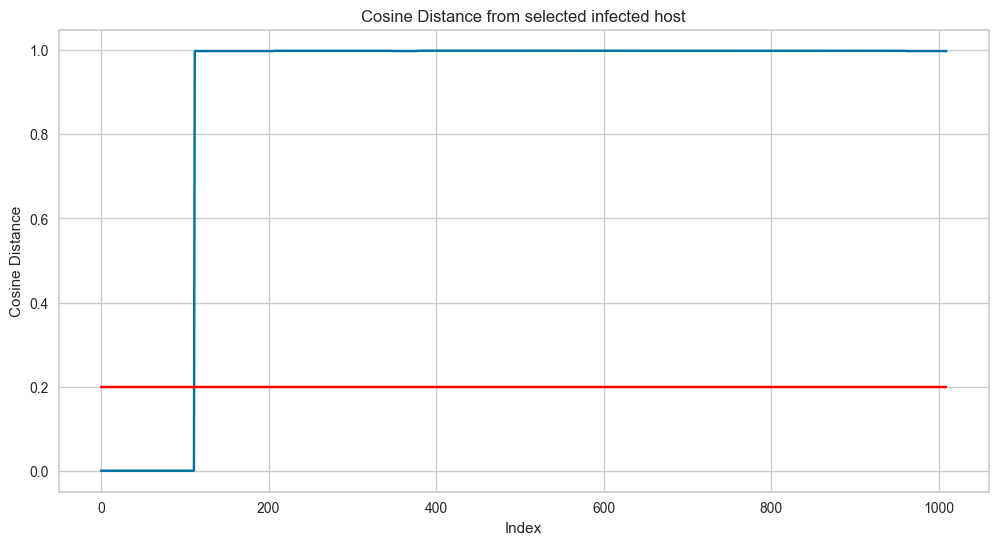

In [389]:
# plot cosine distance vs row number
plt.figure(figsize=(12, 6))
plt.plot(first_row_distances)
plt.plot(range(len(first_row_distances)), np.array([0.2] * len(first_row_distances)), label='threshold', color='red')
plt.title('Cosine Distance from selected infected host')
plt.xlabel('Index')
plt.ylabel('Cosine Distance')
plt.show()

In [399]:
# make predictions based on threshold
predictions = np.array(first_row_distances.reshape(-1) < 0.2).astype(int)
test_df['predictions'] = predictions

# confusion matrix of predictions and infections
confusion_matrix(np.array(test_df.label), np.array(test_df.predictions))

array([[898, 102],
       [  0,  10]], dtype=int64)

In [391]:
# find expected values for each state-symbol combination
expectations = features.mean()
expectations

-1_0.0       6.025743
-1_3.0       0.059406
-1_5.0       6.331683
-1_2.0       8.122772
-1_1.0    2302.705941
-1_4.0       0.001980
dtype: float64

In [392]:
test_df[:20]

,SrcAddr,-1_0.0,-1_3.0,-1_5.0,-1_2.0,-1_1.0,-1_4.0,label,predictions
0,147.32.84.165,25.0,0.0,42.0,29.0,19964.0,0.0,1,1
1,147.32.84.191,23.0,0.0,39.0,27.0,21799.0,2.0,1,1
2,147.32.84.192,17.0,0.0,28.0,25.0,21700.0,0.0,1,1
3,147.32.84.193,26.0,0.0,35.0,28.0,20871.0,0.0,1,1
4,147.32.84.204,17.0,0.0,30.0,25.0,23298.0,0.0,1,1
5,147.32.84.205,19.0,0.0,31.0,32.0,24788.0,0.0,1,1
6,147.32.84.206,19.0,0.0,31.0,26.0,23564.0,0.0,1,1
7,147.32.84.207,17.0,0.0,37.0,30.0,22066.0,0.0,1,1
8,147.32.84.208,16.0,0.0,28.0,31.0,23205.0,0.0,1,1
9,147.32.84.209,36.0,0.0,41.0,27.0,20626.0,0.0,1,1


In [398]:
test_df[201:202]

,SrcAddr,-1_0.0,-1_3.0,-1_5.0,-1_2.0,-1_1.0,-1_4.0,label,predictions
201,1.42.96.250,0.0,0.0,10.0,0.0,0.0,0.0,0,0


In [393]:
print(features)

                -1_0.0  -1_3.0  -1_5.0  -1_2.0   -1_1.0  -1_4.0
147.32.84.165     25.0     0.0    42.0    29.0  19964.0     0.0
147.32.84.191     23.0     0.0    39.0    27.0  21799.0     2.0
147.32.84.192     17.0     0.0    28.0    25.0  21700.0     0.0
147.32.84.193     26.0     0.0    35.0    28.0  20871.0     0.0
147.32.84.204     17.0     0.0    30.0    25.0  23298.0     0.0
...                ...     ...     ...     ...      ...     ...
108.18.245.100     0.0     0.0    10.0     0.0      0.0     0.0
108.18.246.150     0.0     0.0    10.0     0.0      0.0     0.0
108.18.3.146       0.0     0.0    10.0     0.0      0.0     0.0
108.18.54.7        0.0     0.0    10.0     0.0      0.0     0.0
108.18.7.218       0.0     0.0    10.0     0.0      0.0     0.0

[1010 rows x 6 columns]


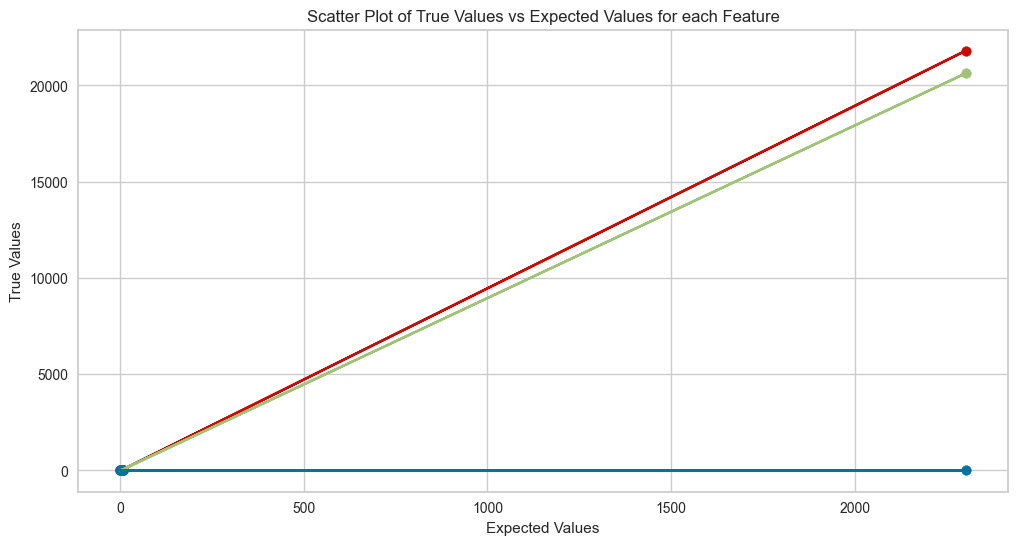

RED LINE: TRUE POSITIVE
GREEN LINE: FALSE POSITIVE
BLUE LINE: TRUE NEGATIVE


In [400]:
true_positive_ip = "147.32.84.191"
false_positive_ip = "1.112.217.186"
true_negative_ip = "1.42.96.250"

ips_plot = [true_positive_ip, false_positive_ip, true_negative_ip]

plot_df = test_df[test_df['SrcAddr'].isin(ips_plot)]

# Plot the scatter plot
plt.figure(figsize=(12, 6))

# Define a color list for each IP
colors = ['r', 'g', 'b']

# Iterate over each feature
for i, ip in enumerate(ips_plot):
    for f in features.columns[:10]:
        if f != 'SrcAddr':  # Exclude the 'SrcAddr' column
            # Plot the expected value of the feature on x-axis and true values on y-axis
            plt.scatter(expectations[f], plot_df[plot_df['SrcAddr'] == ip][f], color=colors[i])

    # Fit a line to the data points and plot this line
    m, b = np.polyfit(expectations[features.columns[:10]], plot_df[plot_df['SrcAddr'] == ip][features.columns[:10]].T, 1)
    plt.plot(expectations[features.columns[:10]], m*expectations[features.columns[:10]] + b, color=colors[i])

# Adding labels and title
plt.xlabel('Expected Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of True Values vs Expected Values for each Feature')

# Create a legend for each IP
# plt.legend()

# Display the plot
plt.show()

print("RED LINE: TRUE POSITIVE")
print("GREEN LINE: FALSE POSITIVE")
print("BLUE LINE: TRUE NEGATIVE")

#### 4b. Analysis and answers to the questions.



For Scenario 10, there are many threshold options, as the signature of the hosts are either very similar or very dissimilar to the reference signature.

 We see that the state **-1_1.0** is frequent among infected hosts. However, it does not really help us distinguish botnets from the rest of benign hosts, leading to a large number of false positives. As such, we cannot state that this is a strong fingerprint of the infected hosts, however it does provide some separation from a large number of benign hosts. The difficulty in classification here is also evident from the scatter plot, where the red and green line almost coincide, indicating the very similar behavior between some benign hosts and an infected one.

### Scenario 11

#### 4a. Learn a sequential model, profiling and fingerprinting

In [401]:
data = pd.read_csv("cda-lab3-botnet-detection\dataset_11\capture20110818-2.binetflow")
preprocessed_data = preprocess_data(data, date_fix=True, remove_background=False, label_enc=True, label_enc_columns=['Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos'])
discr_data = discretize_data(preprocessed_data, ['Proto', 'Dir'], [3, 2])

In [402]:
discr_data['Combined'] = attribute_mappings(discr_data, ['Dir', 'Proto'])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Combined
0,2011-08-18 15:40:53.826372,2.983247,2,76.76.172.248,45579,1,147.32.84.229,1538,148,0,0,3,184,122,0,5.0
1,2011-08-18 15:40:55.435494,2.906029,2,76.76.172.248,45583,1,147.32.84.229,7628,148,0,0,3,184,122,0,5.0
2,2011-08-18 15:40:57.060613,3.030517,2,76.76.172.248,45584,1,147.32.84.229,12186,148,0,0,3,184,122,0,5.0
3,2011-08-18 15:40:56.809619,6.016227,2,76.76.172.248,45579,1,147.32.84.229,1538,148,0,0,3,184,122,0,5.0
4,2011-08-18 15:40:58.341523,6.124715,2,76.76.172.248,45583,1,147.32.84.229,7628,148,0,0,3,184,122,0,5.0


In [403]:
# keep unique values for combined discretized feature
SYMBOLS = discr_data['Combined'].unique()
SYMBOLS

array([5., 2., 0., 3., 4., 1.])

In [404]:
# keep source addresses and labels
ips_with_labels = discr_data[['SrcAddr', 'Label']].groupby(by='SrcAddr').max()
ips_with_labels = ips_with_labels.reset_index()
ips_with_labels

,SrcAddr,Label
0,0.0.0.0,0
1,00:00:00:00:00:00,0
2,00:15:17:2c:e5:2d,0
3,1.112.197.149,0
4,1.112.230.250,0
...,...,...
29152,fe80::5054:ff:fe89:354,0
29153,fe80::5054:ff:feef:6697,0
29154,fe80::7272:cfff:fe1b:d243,0
29155,fe80::d036:46ef:ad35:fc09,0


In [405]:
# separate infected and benign IPs
infected_ips = ips_with_labels[ips_with_labels.Label == "1"]['SrcAddr'].to_list()
benign_ips = ips_with_labels[ips_with_labels.Label == "0"]['SrcAddr'].to_list()

# print the number of infected and benign IPs
len(infected_ips), len(benign_ips)

(3, 29154)

In [406]:
# signature generator for a single IP
def gen_signature(host_data, host_ip, is_train=True):
    
    # dict for host IP signature
    signature = {}
    signature[host_ip] = {}
    
    # data contain: IP, Label, Combined feature (Proto-Direction)
    # renaming for FlexFringe
    flex_data = host_data[['SrcAddr', 'Label', 'Combined']]
    flex_data = flex_data.rename(columns={
        'SrcAddr': 'id',
        'Label': 'type',
        'Combined': 'symb'
    })
    flex_data.to_csv('flex_fringe_files/flex_trace.csv', index=None)
    
    # train mode
    # train FlexFringe on the data to get a signature/ states-transition counts
    if is_train:
        FLEXFRINGE = FlexFringe(
            flexfringe_path="./flexfringe-x64-windows.exe",
            heuristic_name="alergia",
            data_name="alergia_data",
            slidingwindow=1,
            swsize=10
        )
        # Learn a state machine
        FLEXFRINGE.fit('./flex_fringe_files/flex_trace.csv')
    
    else:
        # Use state machine to predict likelihoods
        df = FLEXFRINGE.predict('flex_fringe_files/flex_trace.csv')
        return df
    
  
    # get results from FlexFringe training
    results = None  
    with open('flex_fringe_files/flex_trace.csv.ff.final.json') as f:
        results = json.load(f)
    
    # for every state-symbol combination, compute transition counts
    # and create the profile for this host IP
    for node in results['nodes']:
        # initialize the state-symbol combination
        for symbol in SYMBOLS:
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] = 0.0
            
        # update the state-symbol combination with the transition counts
        for symbol in node['data']['trans_counts'].keys():
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] += int(node['data']['trans_counts'][symbol])
            
    return pd.DataFrame(signature).T

In [407]:
# get first infected host, create its signature
infected_host_sample = discr_data[discr_data.SrcAddr == infected_ips[0]]
print("Infected host IP: ",infected_ips[0])


ref_signature = gen_signature(infected_host_sample, infected_ips[0], is_train=True)
ref_signature = ref_signature.rename_axis('SrcAddr').reset_index()

Infected host IP:  147.32.84.165


In [408]:
# check signature
ref_signature

,SrcAddr,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0
0,147.32.84.165,3.0,0.0,5.0,1.0,8671.0,0.0


In [409]:
# Initialize the signatures DataFrame - for all hosts
signatures = pd.DataFrame()

# Function to collect signatures and labels
def collect_signatures(ips, label):
    global signatures
    # for every IP in the list,
    # generate signature and save it, with label
    for ip in ips:
        host_data = discr_data[discr_data.SrcAddr == ip]
        signature = gen_signature(host_data, ip)
        signature = signature.fillna(0)
        signature['label'] = label
        signatures = pd.concat([signatures, signature])

In [410]:
# NOTE: we keep only the first 1000 benign IPs for computational reasons
# This cell may take around 5 minutes to run
# Adjust number of benign IPs accordingly

# Collect signatures for infected and benign hosts
collect_signatures(infected_ips, 1)
collect_signatures(benign_ips[:1000], 0)

# Save to re-use, if necessary
# signatures = signatures.dropna(axis=1)

# replace na with 0 across axis 1
signatures = signatures.fillna(0)

test_df = signatures.rename_axis('SrcAddr').reset_index()
test_df.to_csv('flex_fringe_files/dataset_11/signatures.csv', index=None)

In [411]:
test_df

,SrcAddr,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,label
0,147.32.84.165,3.0,0.0,5.0,1.0,8671.0,0.0,1
1,147.32.84.191,3.0,0.0,5.0,1.0,8369.0,2.0,1
2,147.32.84.192,3.0,0.0,5.0,1.0,8369.0,2.0,1
3,0.0.0.0,3.0,0.0,5.0,1.0,8369.0,2.0,0
4,00:00:00:00:00:00,3.0,0.0,5.0,1.0,8369.0,2.0,0
...,...,...,...,...,...,...,...,...
998,109.87.39.94,20.0,0.0,0.0,0.0,0.0,0.0,0
999,109.87.72.6,20.0,0.0,0.0,0.0,0.0,0.0,0
1000,109.87.77.60,20.0,0.0,0.0,0.0,0.0,0.0,0
1001,109.88.35.70,20.0,0.0,0.0,0.0,0.0,0.0,0


In [412]:
signatures

,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,label
147.32.84.165,3.0,0.0,5.0,1.0,8671.0,0.0,1
147.32.84.191,3.0,0.0,5.0,1.0,8369.0,2.0,1
147.32.84.192,3.0,0.0,5.0,1.0,8369.0,2.0,1
0.0.0.0,3.0,0.0,5.0,1.0,8369.0,2.0,0
00:00:00:00:00:00,3.0,0.0,5.0,1.0,8369.0,2.0,0
...,...,...,...,...,...,...,...
109.87.39.94,20.0,0.0,0.0,0.0,0.0,0.0,0
109.87.72.6,20.0,0.0,0.0,0.0,0.0,0.0,0
109.87.77.60,20.0,0.0,0.0,0.0,0.0,0.0,0
109.88.35.70,20.0,0.0,0.0,0.0,0.0,0.0,0


In [413]:
# Extract the relevant columns (last 4 columns in this case)
features = signatures.drop('label', axis=1)

# Calculate cosine similarity
cos_sim = cosine_similarity(features)

# Convert cosine similarity to cosine distance
cos_dist = 1-cos_sim

# Display the cosine distances between the selected infected host and all others
first_row_distances = cos_dist[0]
print("Cosine distances from selected infected host to all other hosts:")
print(first_row_distances)

Cosine distances from selected infected host to all other hosts:
[0.00000000e+00 2.88581163e-08 2.88581163e-08 ... 9.99654019e-01
 9.99654019e-01 9.99654019e-01]


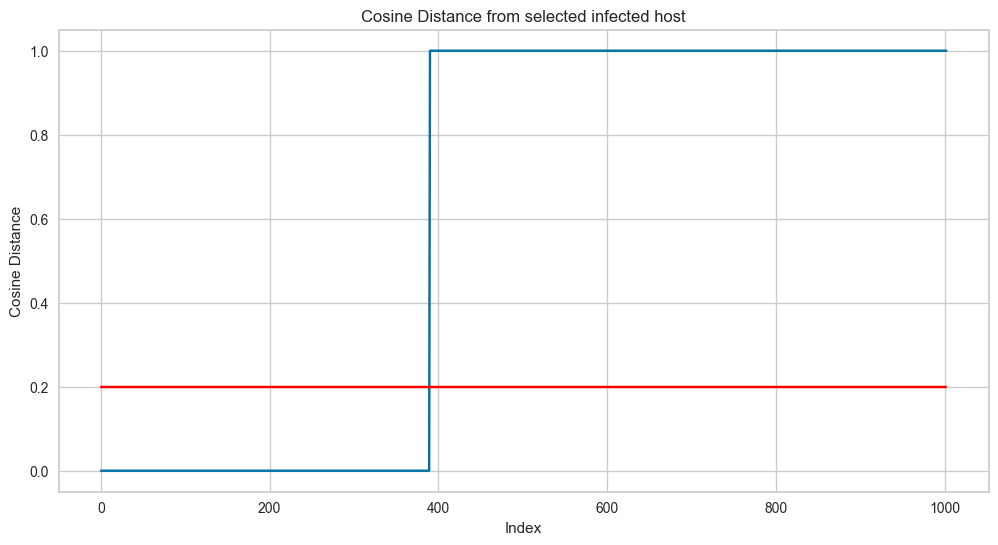

In [415]:
# plot cosine distance vs row number
plt.figure(figsize=(12, 6))
plt.plot(first_row_distances)
plt.plot(range(len(first_row_distances)), np.array([0.2] * len(first_row_distances)), label='threshold', color='red')
plt.title('Cosine Distance from selected infected host')
plt.xlabel('Index')
plt.ylabel('Cosine Distance')
plt.show()

In [418]:
# make predictions based on threshold
predictions = np.array(first_row_distances.reshape(-1) < 0.2).astype(int)
test_df['predictions'] = predictions

# confusion matrix of predictions and infections
confusion_matrix(np.array(test_df.label), np.array(test_df.predictions))

array([[613, 387],
       [  0,   3]], dtype=int64)

In [417]:
# find expected values for each state-symbol combination
expectations = features.mean()
expectations

-1_5.0      13.389831
-1_2.0       0.000000
-1_0.0       1.944167
-1_3.0       0.388833
-1_4.0    3254.448654
-1_1.0       0.775673
dtype: float64

In [419]:
test_df[:20]

,SrcAddr,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,label,predictions
0,147.32.84.165,3.0,0.0,5.0,1.0,8671.0,0.0,1,1
1,147.32.84.191,3.0,0.0,5.0,1.0,8369.0,2.0,1,1
2,147.32.84.192,3.0,0.0,5.0,1.0,8369.0,2.0,1,1
3,0.0.0.0,3.0,0.0,5.0,1.0,8369.0,2.0,0,1
4,00:00:00:00:00:00,3.0,0.0,5.0,1.0,8369.0,2.0,0,1
5,00:15:17:2c:e5:2d,3.0,0.0,5.0,1.0,8369.0,2.0,0,1
6,1.112.197.149,3.0,0.0,5.0,1.0,8369.0,2.0,0,1
7,1.112.230.250,3.0,0.0,5.0,1.0,8369.0,2.0,0,1
8,1.113.221.81,3.0,0.0,5.0,1.0,8369.0,2.0,0,1
9,1.113.99.203,3.0,0.0,5.0,1.0,8369.0,2.0,0,1


In [420]:
test_df[601:602]

,SrcAddr,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,label,predictions
601,109.185.31.91,20.0,0.0,0.0,0.0,0.0,0.0,0,0


In [421]:
print(features)

                   -1_5.0  -1_2.0  -1_0.0  -1_3.0  -1_4.0  -1_1.0
147.32.84.165         3.0     0.0     5.0     1.0  8671.0     0.0
147.32.84.191         3.0     0.0     5.0     1.0  8369.0     2.0
147.32.84.192         3.0     0.0     5.0     1.0  8369.0     2.0
0.0.0.0               3.0     0.0     5.0     1.0  8369.0     2.0
00:00:00:00:00:00     3.0     0.0     5.0     1.0  8369.0     2.0
...                   ...     ...     ...     ...     ...     ...
109.87.39.94         20.0     0.0     0.0     0.0     0.0     0.0
109.87.72.6          20.0     0.0     0.0     0.0     0.0     0.0
109.87.77.60         20.0     0.0     0.0     0.0     0.0     0.0
109.88.35.70         20.0     0.0     0.0     0.0     0.0     0.0
109.88.40.107        20.0     0.0     0.0     0.0     0.0     0.0

[1003 rows x 6 columns]


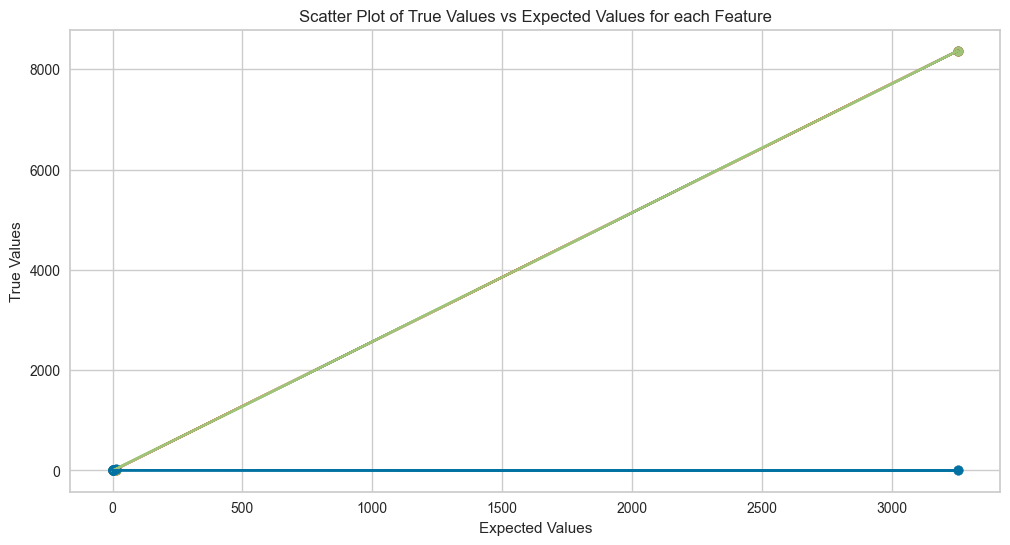

RED LINE: TRUE POSITIVE
GREEN LINE: FALSE POSITIVE
BLUE LINE: TRUE NEGATIVE


In [422]:
true_positive_ip = "147.32.84.191"
false_positive_ip = "1.153.209.213"
true_negative_ip = "109.185.31.91"

ips_plot = [true_positive_ip, false_negative_ip, true_negative_ip]

plot_df = test_df[test_df['SrcAddr'].isin(ips_plot)]

# Plot the scatter plot
plt.figure(figsize=(12, 6))

# Define a color list for each IP
colors = ['r', 'g', 'b']

# Iterate over each feature
for i, ip in enumerate(ips_plot):
    for f in features.columns[:10]:
        if f != 'SrcAddr':  # Exclude the 'SrcAddr' column
            # Plot the expected value of the feature on x-axis and true values on y-axis
            plt.scatter(expectations[f], plot_df[plot_df['SrcAddr'] == ip][f], color=colors[i])

    # Fit a line to the data points and plot this line
    m, b = np.polyfit(expectations[features.columns[:10]], plot_df[plot_df['SrcAddr'] == ip][features.columns[:10]].T, 1)
    plt.plot(expectations[features.columns[:10]], m*expectations[features.columns[:10]] + b, color=colors[i])

# Adding labels and title
plt.xlabel('Expected Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of True Values vs Expected Values for each Feature')

# Create a legend for each IP
# plt.legend()

# Display the plot
plt.show()

print("RED LINE: TRUE POSITIVE")
print("GREEN LINE: FALSE POSITIVE")
print("BLUE LINE: TRUE NEGATIVE")

#### 4b. Analysis and answers to the questions.

For Scenario 11, the situation is similar as in Scenario 10, however now even more benign hosts are similar to the few infected ones.

 We see that the state **-1_4.0** is frequent among infected hosts. However, again, this state does not have any discriminative insights over the hosts, as there is a large number of benign hosts with similar behavior to the infected ones. The plot shows that the red and green line perfectly coincide for the selected states, showcasing the difficulty of predicting botnets with this scenario and aggregated, discretized features.

### Scenario 12

#### 4a. Learn a sequential model, profiling and fingerprinting

In [423]:
data = pd.read_csv("cda-lab3-botnet-detection\dataset_12\capture20110819.binetflow")
preprocessed_data = preprocess_data(data, date_fix=True, remove_background=False, label_enc=True, label_enc_columns=['Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos'])
discr_data = discretize_data(preprocessed_data, ['Proto', 'Dir'], [3, 2])

In [424]:
discr_data['Combined'] = attribute_mappings(discr_data, ['Dir', 'Proto'])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Combined
0,2011-08-19 10:32:31.926442,3.003373,2,147.32.86.194,27569,1,77.75.73.9,27885,142,0,0,3,182,122,0,5.0
1,2011-08-19 10:37:05.849782,0.967492,2,147.32.3.51,500,1,147.32.87.22,1939,146,0,0,4,244,124,0,5.0
2,2011-08-19 10:38:48.257124,0.000000,2,60.2.174.102,53354,1,147.32.85.48,7551,88,0,4,1,60,60,0,5.0
3,2011-08-19 10:41:12.342795,1.391385,2,200.99.228.67,17255,1,147.32.87.62,2158,146,0,0,4,244,124,0,5.0
4,2011-08-19 10:44:52.276736,1.124664,2,147.32.3.51,773,1,147.32.84.46,1939,146,0,0,4,244,124,0,5.0


In [425]:
# keep unique values for combined discretized feature
SYMBOLS = discr_data['Combined'].unique()
SYMBOLS

array([5., 2., 0., 3., 4., 1.])

In [426]:
# keep source addresses and labels
ips_with_labels = discr_data[['SrcAddr', 'Label']].groupby(by='SrcAddr').max()
ips_with_labels = ips_with_labels.reset_index()
ips_with_labels

,SrcAddr,Label
0,0.0.0.0,0
1,00:0c:29:97:a3:eb,0
2,00:15:17:2c:e5:2d,0
3,1.11.27.186,0
4,1.112.144.58,0
...,...,...
59547,fe80::5054:ff:fe89:354,0
59548,fe80::5054:ff:feef:6697,0
59549,fe80::7272:cfff:fe1b:d243,0
59550,fe80::d036:46ef:ad35:fc09,0


In [427]:
# separate infected and benign IPs
infected_ips = ips_with_labels[ips_with_labels.Label == "1"]['SrcAddr'].to_list()
benign_ips = ips_with_labels[ips_with_labels.Label == "0"]['SrcAddr'].to_list()

# print the number of infected and benign IPs
len(infected_ips), len(benign_ips)

(9, 59543)

In [428]:
# signature generator for a single IP
def gen_signature(host_data, host_ip, is_train=True):
    
    # dict for host IP signature
    signature = {}
    signature[host_ip] = {}
    
    # data contain: IP, Label, Combined feature (Proto-Direction)
    # renaming for FlexFringe
    flex_data = host_data[['SrcAddr', 'Label', 'Combined']]
    flex_data = flex_data.rename(columns={
        'SrcAddr': 'id',
        'Label': 'type',
        'Combined': 'symb'
    })
    flex_data.to_csv('flex_fringe_files/flex_trace.csv', index=None)
    
    # train mode
    # train FlexFringe on the data to get a signature/ states-transition counts
    if is_train:
        FLEXFRINGE = FlexFringe(
            flexfringe_path="./flexfringe-x64-windows.exe",
            heuristic_name="alergia",
            data_name="alergia_data",
            slidingwindow=1,
            swsize=10
        )
        # Learn a state machine
        FLEXFRINGE.fit('./flex_fringe_files/flex_trace.csv')
    
    else:
        # Use state machine to predict likelihoods
        df = FLEXFRINGE.predict('flex_fringe_files/flex_trace.csv')
        return df
    
  
    # get results from FlexFringe training
    results = None  
    with open('flex_fringe_files/flex_trace.csv.ff.final.json') as f:
        results = json.load(f)
    
    # for every state-symbol combination, compute transition counts
    # and create the profile for this host IP
    for node in results['nodes']:
        # initialize the state-symbol combination
        for symbol in SYMBOLS:
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] = 0.0
            
        # update the state-symbol combination with the transition counts
        for symbol in node['data']['trans_counts'].keys():
            state_symbol = f'{node["id"]}_{symbol}'
            signature[host_ip][state_symbol] += int(node['data']['trans_counts'][symbol])
            
    return pd.DataFrame(signature).T

In [431]:
# get first infected host, create its signature
infected_host_sample = discr_data[discr_data.SrcAddr == infected_ips[0]]
print("Infected host IP: ",infected_ips[0])


ref_signature = gen_signature(infected_host_sample, infected_ips[0], is_train=True)
ref_signature = ref_signature.rename_axis('SrcAddr').reset_index()

Infected host IP:  147.32.84.165


In [432]:
# check signature
ref_signature

,SrcAddr,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,38_5.0,38_2.0,38_0.0,38_3.0,38_4.0,38_1.0,228_5.0,228_2.0,228_0.0,228_3.0,228_4.0,228_1.0
0,147.32.84.165,130.0,2.0,629.0,247.0,26.0,0.0,90.0,0.0,66.0,9.0,6.0,0.0,2.0,0.0,196.0,277.0,0.0,0.0


In [433]:
# Initialize the signatures DataFrame - for all hosts
signatures = pd.DataFrame()

# Function to collect signatures and labels
def collect_signatures(ips, label):
    global signatures
    # for every IP in the list,
    # generate signature and save it, with label
    for ip in ips:
        host_data = discr_data[discr_data.SrcAddr == ip]
        signature = gen_signature(host_data, ip)
        signature = signature.fillna(0)
        signature['label'] = label
        signatures = pd.concat([signatures, signature])

In [434]:
# NOTE: we keep only the first 1000 benign IPs for computational reasons
# This cell may take around 5 minutes to run
# Adjust number of benign IPs accordingly

# Collect signatures for infected and benign hosts
collect_signatures(infected_ips, 1)
collect_signatures(benign_ips[:1000], 0)

# Save to re-use, if necessary
# signatures = signatures.dropna(axis=1)

# replace na with 0 across axis 1
signatures = signatures.fillna(0)

test_df = signatures.rename_axis('SrcAddr').reset_index()
test_df.to_csv('flex_fringe_files/dataset_12/signatures.csv', index=None)

In [435]:
test_df

,SrcAddr,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,38_5.0,38_2.0,38_0.0,38_3.0,38_4.0,38_1.0,228_5.0,228_2.0,228_0.0,228_3.0,228_4.0,228_1.0,label,20_5.0,20_2.0,20_0.0,20_3.0,20_4.0,20_1.0,25_5.0,25_2.0,25_0.0,25_3.0,25_4.0,25_1.0,183_5.0,183_2.0,183_0.0,183_3.0,183_4.0,183_1.0
0,147.32.84.165,130.0,2.0,629.0,247.0,26.0,0.0,90.0,0.0,66.0,9.0,6.0,0.0,2.0,0.0,196.0,277.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,147.32.84.191,122.0,2.0,635.0,601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,128.0,0.0,94.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,147.32.84.192,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0
3,161.200.133.204,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0
4,222.160.227.154,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,109.164.207.2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,109.164.211.195,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,109.164.230.173,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,109.164.246.132,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [436]:
signatures

,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,38_5.0,38_2.0,38_0.0,38_3.0,38_4.0,38_1.0,228_5.0,228_2.0,228_0.0,228_3.0,228_4.0,228_1.0,label,20_5.0,20_2.0,20_0.0,20_3.0,20_4.0,20_1.0,25_5.0,25_2.0,25_0.0,25_3.0,25_4.0,25_1.0,183_5.0,183_2.0,183_0.0,183_3.0,183_4.0,183_1.0
147.32.84.165,130.0,2.0,629.0,247.0,26.0,0.0,90.0,0.0,66.0,9.0,6.0,0.0,2.0,0.0,196.0,277.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147.32.84.191,122.0,2.0,635.0,601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,128.0,0.0,94.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147.32.84.192,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0
161.200.133.204,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0
222.160.227.154,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109.164.207.2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109.164.211.195,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109.164.230.173,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109.164.246.132,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [437]:
# Extract the relevant columns (last 4 columns in this case)
features = signatures.drop('label', axis=1)

# Calculate cosine similarity
cos_sim = cosine_similarity(features)

# Convert cosine similarity to cosine distance
cos_dist = 1-cos_sim

# Display the cosine distances between the selected infected host and all others
first_row_distances = cos_dist[0]
print("Cosine distances from selected infected host to all other hosts:")
print(first_row_distances)

Cosine distances from selected infected host to all other hosts:
[2.22044605e-16 1.89976422e-01 5.62993562e-01 ... 8.32443060e-01
 8.32443060e-01 8.32443060e-01]


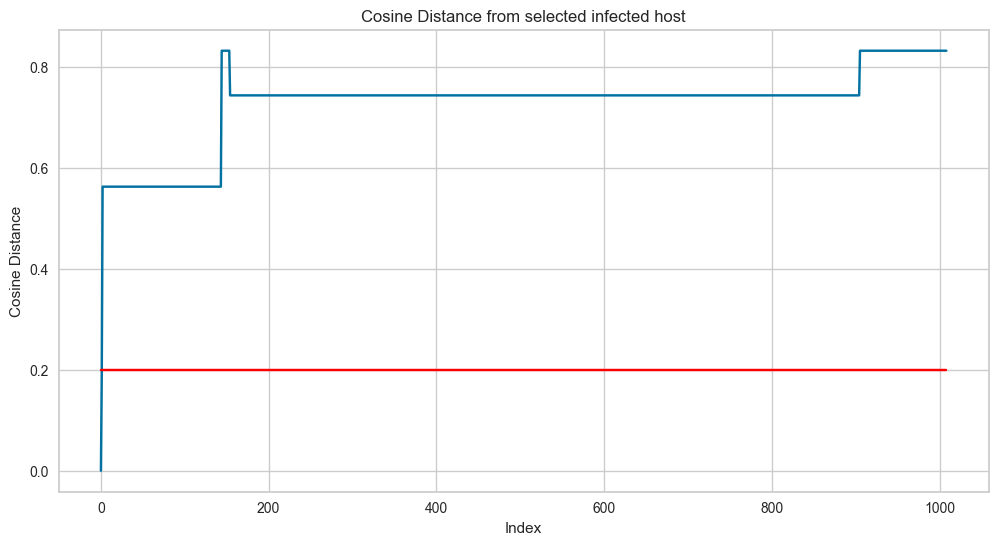

In [453]:
# plot cosine distance vs row number
plt.figure(figsize=(12, 6))
plt.plot(first_row_distances)
plt.plot(range(len(first_row_distances)), np.array([0.2] * len(first_row_distances)), label='threshold', color='red')
plt.title('Cosine Distance from selected infected host')
plt.xlabel('Index')
plt.ylabel('Cosine Distance')
plt.show()

In [454]:
# make predictions based on threshold
predictions = np.array(first_row_distances.reshape(-1) < 0.2).astype(int)
test_df['predictions'] = predictions

# confusion matrix of predictions and infections
confusion_matrix(np.array(test_df.label), np.array(test_df.predictions))

array([[1000,    0],
       [   7,    2]], dtype=int64)

In [455]:
# find expected values for each state-symbol combination
expectations = features.mean()
expectations

-1_5.0     24.403370
-1_2.0      0.285431
-1_0.0     30.706640
-1_3.0     13.084242
-1_4.0      0.025768
-1_1.0      0.000000
38_5.0      0.089197
38_2.0      0.000000
38_0.0      0.065411
38_3.0      0.008920
38_4.0      0.005946
38_1.0      0.000000
228_5.0     0.001982
228_2.0     0.000000
228_0.0     0.194252
228_3.0     0.274529
228_4.0     0.000000
228_1.0     0.000000
20_5.0      0.126858
20_2.0      0.000000
20_0.0      0.093162
20_3.0      0.007929
20_4.0      0.000000
20_1.0      0.000000
25_5.0     16.325074
25_2.0      0.000000
25_0.0     12.103072
25_3.0      0.985134
25_4.0      0.000000
25_1.0      0.000000
183_5.0     1.688801
183_2.0     0.000000
183_0.0    34.761150
183_3.0    42.642220
183_4.0     0.000000
183_1.0     0.000000
dtype: float64

In [456]:
test_df[:20]

,SrcAddr,-1_5.0,-1_2.0,-1_0.0,-1_3.0,-1_4.0,-1_1.0,38_5.0,38_2.0,38_0.0,38_3.0,38_4.0,38_1.0,228_5.0,228_2.0,228_0.0,228_3.0,228_4.0,228_1.0,label,20_5.0,20_2.0,20_0.0,20_3.0,20_4.0,20_1.0,25_5.0,25_2.0,25_0.0,25_3.0,25_4.0,25_1.0,183_5.0,183_2.0,183_0.0,183_3.0,183_4.0,183_1.0,predictions
0,147.32.84.165,130.0,2.0,629.0,247.0,26.0,0.0,90.0,0.0,66.0,9.0,6.0,0.0,2.0,0.0,196.0,277.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,147.32.84.191,122.0,2.0,635.0,601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,128.0,0.0,94.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,147.32.84.192,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0
3,161.200.133.204,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0
4,222.160.227.154,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0
5,69.104.66.134,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0
6,91.188.37.153,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0
7,93.103.254.175,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0
8,95.65.17.47,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0
9,0.0.0.0,116.0,2.0,204.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,86.0,7.0,0.0,0.0,12.0,0.0,247.0,303.0,0.0,0.0,0


In [457]:
print(features)

                 -1_5.0  -1_2.0  -1_0.0  -1_3.0  -1_4.0  -1_1.0  38_5.0  \
147.32.84.165     130.0     2.0   629.0   247.0    26.0     0.0    90.0   
147.32.84.191     122.0     2.0   635.0   601.0     0.0     0.0     0.0   
147.32.84.192     116.0     2.0   204.0    87.0     0.0     0.0     0.0   
161.200.133.204   116.0     2.0   204.0    87.0     0.0     0.0     0.0   
222.160.227.154   116.0     2.0   204.0    87.0     0.0     0.0     0.0   
...                 ...     ...     ...     ...     ...     ...     ...   
109.164.207.2      10.0     0.0     0.0     0.0     0.0     0.0     0.0   
109.164.211.195    10.0     0.0     0.0     0.0     0.0     0.0     0.0   
109.164.230.173    10.0     0.0     0.0     0.0     0.0     0.0     0.0   
109.164.246.132    10.0     0.0     0.0     0.0     0.0     0.0     0.0   
109.164.3.88       10.0     0.0     0.0     0.0     0.0     0.0     0.0   

                 38_2.0  38_0.0  38_3.0  38_4.0  38_1.0  228_5.0  228_2.0  \
147.32.84.165       0.

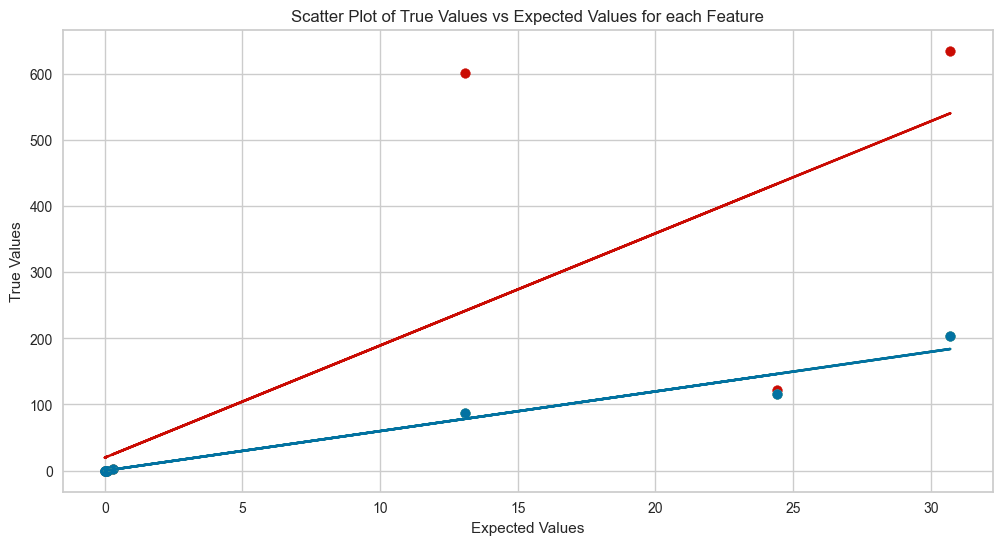

RED LINE: TRUE POSITIVE
GREEN LINE: FALSE NEGATIVE
BLUE LINE: TRUE NEGATIVE


In [458]:
true_positive_ip = "147.32.84.191"
false_negative_ip = "147.32.84.192"
true_negative_ip = "1.112.58.170"

ips_plot = [true_positive_ip, false_negative_ip, true_negative_ip]

plot_df = test_df[test_df['SrcAddr'].isin(ips_plot)]

# Plot the scatter plot
plt.figure(figsize=(12, 6))

# Define a color list for each IP
colors = ['r', 'g', 'b']

# Iterate over each feature
for i, ip in enumerate(ips_plot):
    for f in features.columns[:10]:
        if f != 'SrcAddr':  # Exclude the 'SrcAddr' column
            # Plot the expected value of the feature on x-axis and true values on y-axis
            plt.scatter(expectations[f], plot_df[plot_df['SrcAddr'] == ip][f], color=colors[i])

    # Fit a line to the data points and plot this line
    m, b = np.polyfit(expectations[features.columns[:10]], plot_df[plot_df['SrcAddr'] == ip][features.columns[:10]].T, 1)
    plt.plot(expectations[features.columns[:10]], m*expectations[features.columns[:10]] + b, color=colors[i])

# Adding labels and title
plt.xlabel('Expected Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of True Values vs Expected Values for each Feature')

# Create a legend for each IP
# plt.legend()

# Display the plot
plt.show()

print("RED LINE: TRUE POSITIVE")
print("GREEN LINE: FALSE NEGATIVE")
print("BLUE LINE: TRUE NEGATIVE")

#### 4b. Analysis and answers to the questions.

For Scenario 12, there are some clear threshold options. By selecting 0.2, we become more strict and precisely predict 2 out of 9 infected hosts. However, if we chose a threshold around 0.6, we would be able to predict all infected hosts, but also mislabel around 150 benign hosts.

We see that the state **-1_0.0** is frequent among infected hosts. However, it is more distinct for the first two infected hosts (that are correctly predicted). The rest have less visits to this state, leading to them being more similar to a number of benign hosts.